Download the dataset from Kaggle and prepare the data

# 🎵 Music Genre Classification with MLP and LSTM Models

In this project, we replicate and analyze the performance of neural network models for automatic music genre classification using the **GTZAN dataset**.  
We experiment with both **feed-forward MLPs** and **LSTM sequence models** on 3-, 6-, and 9-second feature segments derived from 30-second clips.

Our goals are to:
- Recreate the experimental setup described in the reference paper.
- Evaluate **window-level vs. clip-level accuracy** for short feature vectors.
- Investigate whether **temporal modeling** with LSTMs improves genre classification.
- Compare our results to the reported baselines and analyze any discrepancies.

In [1]:
!pip install kaggle
from google.colab import files

files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


### Data Loading and Feature Preparation

Each 30-second audio file in GTZAN is represented by:
- A **30-second feature vector** (for the MLP baseline).
- Ten **3-second feature vectors** extracted from that clip (for the LSTM model).

These features capture short-term timbral and rhythmic information such as MFCCs, chroma, and spectral contrast.  
We perform standard preprocessing steps:
- Encoding genre labels into integers.  
- Scaling features using `StandardScaler` (fit on the full dataset, intentionally leaky to mirror the original paper).  
- Stratified splitting into train/test sets (80/20).


In [2]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification.zip -d ./gtzan


Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtzan-dataset-music-genre-classification.zip
replace ./gtzan/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./gtzan/Data/features_30_sec.csv  
  inflating: ./gtzan/Data/features_3_sec.csv  
  inflating: ./gtzan/Data/genres_original/blues/blues.00000.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00001.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00002.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00003.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00004.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00005.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00006.wav  
  inflating: ./gtzan/Data/genres_original/blues/blues.00007

In [3]:
import pandas as pd

# Paths to the files
features_30_path = "/content/gtzan/Data/features_30_sec.csv"
features_3_path  = "/content/gtzan/Data/features_3_sec.csv"

df_30 = pd.read_csv(features_30_path)
df_3 = pd.read_csv(features_3_path)

We apply normalization to standardize the feature vectors data in preprocessing.

In [4]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# 30s features (MLP-30)
X_30 = df_30.drop(columns=['label', 'filename']).values.astype('float32')
y_30_str = df_30['label'].values

# 3s windows (MLP-3 + LSTM sequences source)
X_3_full = df_3.drop(columns=['label'])
filenames_3 = X_3_full['filename'].values
X_3 = X_3_full.drop(columns=['filename']).values.astype('float32')
y_3_str = df_3['label'].values

# labels
enc = LabelEncoder()
y_30 = enc.fit_transform(y_30_str).astype(np.int64)
y_3  = enc.transform(y_3_str).astype(np.int64)
LABELS = list(enc.classes_)
num_classes = len(LABELS)

X_tr30, X_te30, y_tr30, y_te30 = train_test_split(
    X_30, y_30, test_size=0.2, random_state=42, stratify=y_30
)

X_tr3, X_te3, y_tr3, y_te3, fn_tr3, fn_te3 = train_test_split(
    X_3, y_3, filenames_3, test_size=0.2, random_state=42, stratify=y_3
)

sc30 = StandardScaler().fit(X_30)
sc3  = StandardScaler().fit(X_3)

X_tr30 = sc30.transform(X_tr30).astype('float32')
X_te30 = sc30.transform(X_te30).astype('float32')
X_tr3  = sc3.transform(X_tr3).astype('float32')
X_te3  = sc3.transform(X_te3).astype('float32')


Create training and testing dataset for 30 and 3 second feature vectors

We use a batch size of 4 for the MLP to stay faithful to the paper.

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_MLP = 4  # per the paper for the MLP baseline
dl_tr30 = DataLoader(TensorDataset(torch.from_numpy(X_tr30), torch.from_numpy(y_tr30)),
                     batch_size=BATCH_MLP, shuffle=True, num_workers=0)
dl_te30 = DataLoader(TensorDataset(torch.from_numpy(X_te30), torch.from_numpy(y_te30)),
                     batch_size=BATCH_MLP, shuffle=False, num_workers=0)

dl_tr3 = DataLoader(TensorDataset(torch.from_numpy(X_tr3), torch.from_numpy(y_tr3)),
                    batch_size=BATCH_MLP, shuffle=True, num_workers=0)
dl_te3 = DataLoader(TensorDataset(torch.from_numpy(X_te3), torch.from_numpy(y_te3)),
                    batch_size=BATCH_MLP, shuffle=False, num_workers=0)


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import os, re

# filenames_3 : (9990,) like 'blues.00000.3.wav'
def to_song_id(fname: str):
    base = os.path.basename(fname)
    return re.sub(r'\.\d+(\.wav)$', r'\1', base, flags=re.IGNORECASE).lower()

song_ids = np.array([to_song_id(f) for f in filenames_3])
unique_songs = np.unique(song_ids)

# stratify by label at clip level
# map each song_id -> its label (take label of first window of that clip)
song2label = {}
for sid in unique_songs:
    i = np.where(song_ids == sid)[0][0]
    song2label[sid] = y_3[i]
clip_labels = np.array([song2label[sid] for sid in unique_songs])

songs_tr, songs_te = train_test_split(
    unique_songs, test_size=0.2, random_state=42, stratify=clip_labels
)

mask_tr = np.isin(song_ids, songs_tr)
mask_te = np.isin(song_ids, songs_te)

X_tr_w, y_tr_w, fn_tr_w = X_3[mask_tr], y_3[mask_tr], filenames_3[mask_tr]
X_te_w, y_te_w, fn_te_w = X_3[mask_te], y_3[mask_te], filenames_3[mask_te]


In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tr_w = sc.fit_transform(X_tr_w).astype('float32')   # fit on train
X_te_w = sc.transform(X_te_w).astype('float32')


In [8]:
from collections import defaultdict
import re

def window_order_key(fname: str):
    m = re.search(r'\.(\d+)\.wav$', fname.lower())
    return int(m.group(1)) if m else 0

def build_sequences_fixedT_all(X_win, y_win, fnames_win, grouping: int):
    # grouping=1->T=10 (3s), 2->T=5 (6s), 3->T=3 (9s)
    T_expected = {1:10, 2:5, 3:3}[grouping]
    step = grouping

    buckets = defaultdict(list)
    for x, y, f in zip(X_win, y_win, fnames_win):
        buckets[to_song_id(f)].append((f, x, y))

    X_seq_list, y_seq_list = [], []
    for sid, items in buckets.items():
        items.sort(key=lambda t: window_order_key(t[0]))
        xs = np.stack([t[1] for t in items], axis=0)   # usually [10,58]
        if xs.shape[0] < step:
            continue
        n_grp = xs.shape[0] // step
        if n_grp != T_expected:
            # require exactly 10 windows per clip so n_grp matches T_expected
            continue
        y = items[0][2]
        xs = xs[:n_grp*step].reshape(n_grp, step, -1).mean(axis=1)  # [T,58]
        X_seq_list.append(xs.astype('float32'))
        y_seq_list.append(y)

    if not X_seq_list:
        return np.zeros((0, T_expected, 58), dtype='float32'), np.zeros((0,), dtype=np.int64)

    X_seq = np.stack(X_seq_list, axis=0)
    y_seq = np.array(y_seq_list, dtype=np.int64)
    return X_seq, y_seq

# Build 3s, 6s, 9s sequences
X3_tr_np, y3_tr_np = build_sequences_fixedT_all(X_tr_w, y_tr_w, fn_tr_w, grouping=1)
X3_te_np, y3_te_np = build_sequences_fixedT_all(X_te_w, y_te_w, fn_te_w, grouping=1)

X6_tr_np, y6_tr_np = build_sequences_fixedT_all(X_tr_w, y_tr_w, fn_tr_w, grouping=2)
X6_te_np, y6_te_np = build_sequences_fixedT_all(X_te_w, y_te_w, fn_te_w, grouping=2)

X9_tr_np, y9_tr_np = build_sequences_fixedT_all(X_tr_w, y_tr_w, fn_tr_w, grouping=3)
X9_te_np, y9_te_np = build_sequences_fixedT_all(X_te_w, y_te_w, fn_te_w, grouping=3)


Create dataloaders for the LSTM. We use 3 second, 6 second, and 9 second sequence clips for the LSTM as per the paper.

Just like the paper, we use a batch size of 16 for the LSTM



In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def make_seq_loader(X_np, y_np, batch=16, shuffle=False):
    X = torch.tensor(X_np, dtype=torch.float32)
    y = torch.tensor(y_np, dtype=torch.long)
    return DataLoader(TensorDataset(X, y),
                      batch_size=batch,
                      shuffle=shuffle,
                      num_workers=0,
                      pin_memory=torch.cuda.is_available())

BATCH = 16  # paper

# 3s loaders
dl_tr_3s = make_seq_loader(X3_tr_np, y3_tr_np, batch=BATCH, shuffle=True)
dl_te_3s = make_seq_loader(X3_te_np, y3_te_np, batch=BATCH, shuffle=False)

# 6s loaders
dl_tr_6s = make_seq_loader(X6_tr_np, y6_tr_np, batch=BATCH, shuffle=True)
dl_te_6s = make_seq_loader(X6_te_np, y6_te_np, batch=BATCH, shuffle=False)

# 9s loaders
dl_tr_9s = make_seq_loader(X9_tr_np, y9_tr_np, batch=BATCH, shuffle=True)
dl_te_9s = make_seq_loader(X9_te_np, y9_te_np, batch=BATCH, shuffle=False)


### Model Architectures

We explore two neural architectures:
1. **MLP (Multilayer Perceptron)** — a simple feed-forward network that treats each feature vector independently.
2. **LSTM (Long Short-Term Memory)** — a recurrent model that captures temporal patterns across consecutive 3-second windows.

While the MLP provides a strong baseline on static features, the LSTM can leverage sequential context and longer-term dependencies between short-time frames.


In [10]:
from torch import nn
class MLPModel(nn.Module):
  def __init__(self, in_features: int,
               hidden_units: int,
               out_features: int,
               dropout: float):

    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(in_features=in_features,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_units,
                  out_features=out_features)
    )

  def forward(self, x):
    return self.mlp(x)

# 3. Window- vs. Clip-Level Accuracy

When using 3-second feature vectors, each 30-second song clip is divided into ten overlapping or adjacent “windows.”
Our MLP model predicts a genre label for every individual 3-second segment, but the ground truth label corresponds to the entire 30-second song.
Because of this mismatch, we track two kinds of accuracy:

Window-level accuracy measures how well the model classifies each individual 3-second segment.
It reflects how consistently the model captures local musical cues such as short rhythmic or harmonic patterns.

Clip-level accuracy aggregates predictions across all 3-second windows belonging to the same song (usually via majority vote or averaging probabilities).
This measures how well the model recognizes the overall genre of a song once all its windows are considered together.

We analyze both metrics because a model might perform well on short fragments (high window-level accuracy) but be inconsistent across an entire song (lower clip-level accuracy).
The clip-level result is typically the more meaningful measure for end-to-end genre recognition, while the window-level result gives insight into local feature learning and temporal stability.

In [11]:
import torch
import torch.nn.functional as F
from collections import defaultdict

@torch.no_grad()
def clip_level_accuracy(model, dataloader_with_names, device):
    model.eval()
    clip_logprobs = defaultdict(list)
    clip_target   = {}

    for X, y, names in dataloader_with_names:
        X, y = X.to(device), y.to(device)
        logits  = model(X)
        logprob = F.log_softmax(logits, 1)
        for lp, t, fname in zip(logprob, y, names):
            key = to_song_id(fname)        # <-- use song id, not raw filename
            clip_logprobs[key].append(lp.cpu())
            clip_target[key] = int(t)

    correct = total = 0
    for key, lps in clip_logprobs.items():
        agg = torch.stack(lps, 0).sum(0)
        pred = int(agg.argmax())
        correct += int(pred == clip_target[key])
        total   += 1
    return 100.0 * correct / total



We define a training loop function for our MLP model

In [12]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader,
          loss_fn, optimizer, epochs=100, device=None,
          eval_every: int = 10,
          clip_eval_loader=None,
          run_name: str = "run", seed: int | None = None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    results = {"train_loss": [], "test_loss": [], "test_acc": [], "test_clip_acc": []}

    for epoch in tqdm(range(epochs)):
        # ---- train ----
        model.train()
        tr_loss_sum, correct, n_tr = 0.0, 0, 0
        for X, y in train_dataloader:
            X = X.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
            logits = model(X)
            loss = loss_fn(logits, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            tr_loss_sum += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            n_tr += y.size(0)
        train_loss = tr_loss_sum / max(1, n_tr)
        train_acc = 100.0 * correct / max(1, n_tr)

        # ---- eval ----
        do_eval = (epoch % eval_every == 0) or (epoch == epochs - 1)
        if do_eval:
            model.eval()
            te_loss_sum, correct, n_te = 0.0, 0, 0
            with torch.inference_mode():
                for X, y in test_dataloader:
                    X = X.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
                    logits = model(X)
                    te_loss_sum += loss_fn(logits, y).item() * y.size(0)
                    correct += (logits.argmax(1) == y).sum().item()
                    n_te += y.size(0)
            test_loss = te_loss_sum / max(1, n_te)
            test_acc  = 100.0 * correct / max(1, n_te)
            print(f"[{run_name} | seed={seed}] Epoch {epoch:03d} | "
                  f"Train {train_loss:.4f} | Test {test_loss:.4f} | Win Acc {test_acc:.2f}%")
        else:
            # carry forward last known metrics (for plotting continuity)
            test_loss = results["test_loss"][-1] if results["test_loss"] else float("nan")
            test_acc  = results["test_acc"][-1] if results["test_acc"] else float("nan")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_clip_acc"].append(None)  # filled only once at the end

    # ---- clip-level eval ONCE at the end (if provided) ----
    if clip_eval_loader is not None:
        final_clip_acc = clip_level_accuracy(model, clip_eval_loader, device)
        results["test_clip_acc"][-1] = final_clip_acc
        print(f"[{run_name} | seed={seed}] [Final] Clip-level accuracy: {final_clip_acc:.2f}%")

    return results









### Training Configuration

To ensure fair and reproducible comparisons:
- We fix random seeds across multiple runs (`42, 123, 999`).
- We use the **Adam optimizer** with learning rates tuned per model type.
- Each model is trained for 50–100 epochs, depending on convergence speed.

We log:
- Training and test losses.
- Window-level and (if applicable) clip-level accuracies.
- Optional sequence-level F1, precision, recall, and confusion matrices.


In [13]:
import numpy as np
import random
import torch

def _set_all_seeds(sd: int):
    random.seed(sd)
    np.random.seed(sd)
    torch.manual_seed(sd)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(sd)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def run_experiment(model_fn,
                   train_loader,
                   test_loader,
                   optimizer_fn,
                   loss_fn,
                   epochs: int = 100,
                   seeds = (42, 123, 999),
                   run_name: str = "Model",
                   device=None,
                   clip_eval_loader=None,
                   eval_every: int = 10,
                   train_fn=None):
    """
    Runs multiple seeds using `train_fn` (defaults to `train`).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if train_fn is None:
        train_fn = train

    histories = []
    final_win_accs, best_win_accs, final_clip_accs = [], [], []

    for sd in seeds:
        print(f"\n--- [{run_name}] Running seed {sd} ---")
        _set_all_seeds(sd)

        model = model_fn().to(device)
        optimizer = optimizer_fn(model)

        hist = train_fn(
            model=model,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epochs=epochs,
            device=device,
            clip_eval_loader=clip_eval_loader,
            eval_every=eval_every,
            run_name=run_name,
            seed=sd
        )

        histories.append(hist)

        # window metrics
        final_win_accs.append(float(hist["test_acc"][-1]))
        best_win_accs.append(float(np.nanmax(hist["test_acc"])))

        # clip metrics (optional)
        if clip_eval_loader is not None and "test_clip_acc" in hist:
            clip_vals = [v for v in hist["test_clip_acc"] if v is not None]
            final_clip_accs.append(float(clip_vals[-1]) if clip_vals else np.nan)

    print(f"\n=== {run_name} Summary over seeds {list(seeds)} ===")
    print(f"Final window accs: {np.round(final_win_accs, 2).tolist()} | "
          f"mean={np.mean(final_win_accs):.2f}% std={np.std(final_win_accs):.2f}")
    print(f"Best  window accs: {np.round(best_win_accs,  2).tolist()} | "
          f"mean={np.mean(best_win_accs):.2f}% std={np.std(best_win_accs):.2f}")
    if clip_eval_loader is not None:
        arr = np.array(final_clip_accs, dtype=float)
        print(f"Final clip    accs: {np.round(arr, 2).tolist()} | "
              f"mean={np.nanmean(arr):.2f}% std={np.nanstd(arr):.2f}")

    summary = {
        "seeds": list(seeds),
        "final_window_accs": final_win_accs,
        "best_window_accs": best_win_accs,
        "final_clip_accs": final_clip_accs if clip_eval_loader is not None else None,
    }
    return histories, summary


In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt

def aggregate_histories(histories):
    """Compute mean/std across seeds for each metric."""
    keys = ['train_loss','train_acc','test_loss','test_acc',
            'test_window_acc','test_clip_acc']
    L = min(len(h[k]) for h in histories for k in keys if k in h)
    agg = {}
    for k in keys:
        runs = [np.array(h[k][:L], dtype=float)
                for h in histories if k in h and h[k] is not None]
        if runs:
            arr = np.stack(runs, axis=0)  # [R, L]
            agg[k] = (np.nanmean(arr, 0), np.nanstd(arr, 0))
        else:
            agg[k] = (None, None)
    return agg, L

def plot_mean_curves(histories, step=10, with_std=True, title="Training curves"):
    agg, L = aggregate_histories(histories)
    epochs = np.arange(L)

    plt.figure(figsize=(13,5))
    # --- Loss ---
    plt.subplot(1,2,1)
    for k, lbl in [('train_loss','Train'),('test_loss','Test')]:
        mu, sd = agg[k]
        if mu is None: continue
        sel = epochs % step == 0
        plt.plot(epochs[sel], mu[sel], marker='o', label=f'{lbl} loss')
        if with_std:
            plt.fill_between(epochs[sel], (mu-sd)[sel], (mu+sd)[sel], alpha=0.15)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

    # --- Accuracy ---
    plt.subplot(1,2,2)
    acc_key = 'test_acc' if agg['test_acc'][0] is not None else 'test_window_acc'
    for k, lbl in [('train_acc','Train'),(acc_key,'Test')]:
        mu, sd = agg[k]
        if mu is None: continue
        sel = epochs % step == 0
        plt.plot(epochs[sel], mu[sel], marker='o', label=f'{lbl} acc')
        if with_std:
            plt.fill_between(epochs[sel], (mu-sd)[sel], (mu+sd)[sel], alpha=0.15)

    # Clip accuracy (optional)
    mu, sd = agg['test_clip_acc']
    if mu is not None and not np.all(np.isnan(mu)):
        sel = epochs % step == 0
        plt.plot(epochs[sel], mu[sel], marker='s', linestyle='--', label='Clip acc')
        if with_std:
            plt.fill_between(epochs[sel], (mu-sd)[sel], (mu+sd)[sel], alpha=0.15)

    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy"); plt.legend()
    plt.suptitle(title)
    plt.tight_layout(); plt.show()


Here we define the function for building a certainty metric to replicate the paper, which defines the certainty as "log of the ratio of the most-likely to second-most-likely genre"

In [15]:
import math, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import torch

@torch.no_grad()
def certainty_table_for_model(model, loader, label_names, device, mode="all"):
    """
    mode: "all" (default) averages certainty over ALL examples of a true class.
          "correct_only" averages only over correctly classified examples of that class.
    Returns: (report_dict, confusion_matrix_ndarray, df) where df has columns:
             ["Genre","Confidence","Recall","Support"]
    """
    model.eval()
    y_true, y_pred = [], []
    top2_margins = []  # log10(p_top/p_second) computed from logits as (z_top - z_2)/ln(10)

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(X)                       # [B, C]
        vals, idxs = torch.topk(logits, k=2, dim=1)
        y_hat = idxs[:, 0]
        margin = (vals[:, 0] - vals[:, 1]) / math.log(10)

        y_true.extend(y.tolist())
        y_pred.extend(y_hat.tolist())
        top2_margins.extend(margin.tolist())

    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    top2_margins = np.asarray(top2_margins, dtype=float)


    rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))

    # Build the per-genre table
    rows = []
    for c_idx, name in enumerate(label_names):
        mask_true = (y_true == c_idx)
        if mode == "correct_only":
            mask = mask_true & (y_pred == c_idx)
        else:
            mask = mask_true

        conf = float(np.mean(top2_margins[mask])) if np.any(mask) else float("nan")
        recall = rep[name]["recall"]  # 0..1
        support = int(rep[name]["support"])
        rows.append({"Genre": name,
                     "Confidence": conf,
                     "Recall": recall,
                     "Support": support})

    df = pd.DataFrame(rows, columns=["Genre","Confidence","Recall","Support"])
    return rep, cm, df

def format_certainty_table(df):
    """Return a display-ready copy like the paper: Confidence with 2 decimals, Recall as % with no decimals."""
    out = df.copy()
    out["Confidence"] = out["Confidence"].astype(float).round(2)
    out["Recall"] = (out["Recall"] * 100.0).round(0).astype(int).astype(str) + "%"
    return out[["Genre","Confidence","Recall"]]


In [16]:
# build a test loader that also yields filenames for clip-level eval
class TensorWithNames(torch.utils.data.Dataset):
    def __init__(self, X, y, names):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.long)
        self.names = list(names)
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i], self.names[i]

test_3_with_names = DataLoader(
    TensorWithNames(X_te3, y_te3, fn_te3),
    batch_size=256,                          # big batch; eval only
    shuffle=False, num_workers=0
)


Here across our experiment runs for our MLP model, we get a best window level accuracy of 80.88% and a best clip level accuracy of 84.10%

In [17]:
# 30s (window==clip)
loss_fn = torch.nn.CrossEntropyLoss()

exp_30, sum_30 = run_experiment(
    model_fn=lambda: MLPModel(58, 13, len(LABELS), 0.2),
    train_loader=dl_tr30,
    test_loader=dl_te30,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
    loss_fn=loss_fn,
    epochs=100,
    seeds=(42,123,999),
    run_name="MLP-30s",
    clip_eval_loader=None,
    eval_every=10,
    device=device,
)

# 3s (needs clip-level aggregation at eval)
exp_3, sum_3 = run_experiment(
    model_fn=lambda: MLPModel(58, 64, len(LABELS), 0.2),
    train_loader=dl_tr3,
    test_loader=dl_te3,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
    loss_fn=loss_fn,
    epochs=100,
    seeds=(42,123,999),
    run_name="MLP-3s",
    clip_eval_loader=test_3_with_names,  # DataLoader yielding (X, y, filename)
    eval_every=10,
    device=device,
)



--- [MLP-30s] Running seed 42 ---


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=42] Epoch 000 | Train 1.6331 | Test 1.2393 | Win Acc 58.00%
[MLP-30s | seed=42] Epoch 010 | Train 0.8668 | Test 1.0192 | Win Acc 66.00%
[MLP-30s | seed=42] Epoch 020 | Train 0.7520 | Test 1.1814 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 030 | Train 0.7263 | Test 1.2374 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 040 | Train 0.7099 | Test 1.6143 | Win Acc 63.50%
[MLP-30s | seed=42] Epoch 050 | Train 0.6409 | Test 1.5272 | Win Acc 65.00%
[MLP-30s | seed=42] Epoch 060 | Train 0.6530 | Test 1.5812 | Win Acc 68.50%
[MLP-30s | seed=42] Epoch 070 | Train 0.6504 | Test 1.6519 | Win Acc 70.50%
[MLP-30s | seed=42] Epoch 080 | Train 0.5769 | Test 1.8254 | Win Acc 69.00%
[MLP-30s | seed=42] Epoch 090 | Train 0.5557 | Test 1.8472 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 099 | Train 0.6162 | Test 1.7034 | Win Acc 69.00%

--- [MLP-30s] Running seed 123 ---


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=123] Epoch 000 | Train 1.6430 | Test 1.2451 | Win Acc 57.00%
[MLP-30s | seed=123] Epoch 010 | Train 0.9460 | Test 1.1114 | Win Acc 62.00%
[MLP-30s | seed=123] Epoch 020 | Train 0.7663 | Test 1.0037 | Win Acc 68.00%
[MLP-30s | seed=123] Epoch 030 | Train 0.7431 | Test 1.0679 | Win Acc 70.00%
[MLP-30s | seed=123] Epoch 040 | Train 0.7600 | Test 1.6350 | Win Acc 64.50%
[MLP-30s | seed=123] Epoch 050 | Train 0.6044 | Test 1.5651 | Win Acc 65.50%
[MLP-30s | seed=123] Epoch 060 | Train 0.5800 | Test 1.5932 | Win Acc 68.00%
[MLP-30s | seed=123] Epoch 070 | Train 0.5887 | Test 1.6213 | Win Acc 65.00%
[MLP-30s | seed=123] Epoch 080 | Train 0.6192 | Test 1.8438 | Win Acc 63.00%
[MLP-30s | seed=123] Epoch 090 | Train 0.6416 | Test 2.1670 | Win Acc 63.00%
[MLP-30s | seed=123] Epoch 099 | Train 0.5418 | Test 2.0998 | Win Acc 65.00%

--- [MLP-30s] Running seed 999 ---


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=999] Epoch 000 | Train 1.6398 | Test 1.1658 | Win Acc 57.00%
[MLP-30s | seed=999] Epoch 010 | Train 0.8722 | Test 1.0961 | Win Acc 66.50%
[MLP-30s | seed=999] Epoch 020 | Train 0.8456 | Test 1.1678 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 030 | Train 0.7767 | Test 1.3705 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 040 | Train 0.7191 | Test 1.5209 | Win Acc 66.00%
[MLP-30s | seed=999] Epoch 050 | Train 0.7100 | Test 1.5006 | Win Acc 63.50%
[MLP-30s | seed=999] Epoch 060 | Train 0.6960 | Test 1.8487 | Win Acc 63.50%
[MLP-30s | seed=999] Epoch 070 | Train 0.6314 | Test 1.9894 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 080 | Train 0.6446 | Test 2.2247 | Win Acc 64.50%
[MLP-30s | seed=999] Epoch 090 | Train 0.6411 | Test 2.1611 | Win Acc 65.00%
[MLP-30s | seed=999] Epoch 099 | Train 0.6032 | Test 2.3443 | Win Acc 67.00%

=== MLP-30s Summary over seeds [42, 123, 999] ===
Final window accs: [69.0, 65.0, 67.0] | mean=67.00% std=1.63
Best  window accs: [70.5, 70.0, 67.5] | m

  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=42] Epoch 000 | Train 1.3074 | Test 1.1827 | Win Acc 62.06%
[MLP-3s | seed=42] Epoch 010 | Train 0.8676 | Test 0.9695 | Win Acc 73.12%
[MLP-3s | seed=42] Epoch 020 | Train 0.7934 | Test 0.8839 | Win Acc 77.78%
[MLP-3s | seed=42] Epoch 030 | Train 0.7921 | Test 0.9705 | Win Acc 75.38%
[MLP-3s | seed=42] Epoch 040 | Train 0.7181 | Test 1.0668 | Win Acc 78.23%
[MLP-3s | seed=42] Epoch 050 | Train 0.7219 | Test 1.1267 | Win Acc 76.83%
[MLP-3s | seed=42] Epoch 060 | Train 0.7297 | Test 1.3493 | Win Acc 77.38%
[MLP-3s | seed=42] Epoch 070 | Train 0.7078 | Test 1.2913 | Win Acc 76.03%
[MLP-3s | seed=42] Epoch 080 | Train 0.6899 | Test 1.2957 | Win Acc 77.83%
[MLP-3s | seed=42] Epoch 090 | Train 0.6399 | Test 1.6044 | Win Acc 76.93%
[MLP-3s | seed=42] Epoch 099 | Train 0.6888 | Test 1.4477 | Win Acc 77.28%
[MLP-3s | seed=42] [Final] Clip-level accuracy: 83.87%

--- [MLP-3s] Running seed 123 ---


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=123] Epoch 000 | Train 1.3226 | Test 1.0364 | Win Acc 67.22%
[MLP-3s | seed=123] Epoch 010 | Train 0.8719 | Test 0.8452 | Win Acc 75.93%
[MLP-3s | seed=123] Epoch 020 | Train 0.7757 | Test 1.0468 | Win Acc 73.52%
[MLP-3s | seed=123] Epoch 030 | Train 0.7480 | Test 0.9302 | Win Acc 77.28%
[MLP-3s | seed=123] Epoch 040 | Train 0.7393 | Test 1.1289 | Win Acc 77.18%
[MLP-3s | seed=123] Epoch 050 | Train 0.7515 | Test 1.2960 | Win Acc 75.38%
[MLP-3s | seed=123] Epoch 060 | Train 0.7317 | Test 1.3369 | Win Acc 75.53%
[MLP-3s | seed=123] Epoch 070 | Train 0.7048 | Test 1.2546 | Win Acc 77.53%
[MLP-3s | seed=123] Epoch 080 | Train 0.6650 | Test 1.3977 | Win Acc 78.28%
[MLP-3s | seed=123] Epoch 090 | Train 0.7110 | Test 1.5049 | Win Acc 76.13%
[MLP-3s | seed=123] Epoch 099 | Train 0.7041 | Test 1.8004 | Win Acc 77.58%
[MLP-3s | seed=123] [Final] Clip-level accuracy: 84.10%

--- [MLP-3s] Running seed 999 ---


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=999] Epoch 000 | Train 1.3084 | Test 0.9986 | Win Acc 66.77%
[MLP-3s | seed=999] Epoch 010 | Train 0.8554 | Test 0.9609 | Win Acc 74.47%
[MLP-3s | seed=999] Epoch 020 | Train 0.7980 | Test 0.8534 | Win Acc 78.53%
[MLP-3s | seed=999] Epoch 030 | Train 0.7558 | Test 1.0712 | Win Acc 76.88%
[MLP-3s | seed=999] Epoch 040 | Train 0.7102 | Test 1.1781 | Win Acc 76.23%
[MLP-3s | seed=999] Epoch 050 | Train 0.7190 | Test 1.0520 | Win Acc 78.03%
[MLP-3s | seed=999] Epoch 060 | Train 0.7363 | Test 1.0659 | Win Acc 79.48%
[MLP-3s | seed=999] Epoch 070 | Train 0.6712 | Test 1.1557 | Win Acc 80.88%
[MLP-3s | seed=999] Epoch 080 | Train 0.7223 | Test 1.3234 | Win Acc 79.18%
[MLP-3s | seed=999] Epoch 090 | Train 0.6737 | Test 1.4259 | Win Acc 78.23%
[MLP-3s | seed=999] Epoch 099 | Train 0.6926 | Test 1.5339 | Win Acc 78.53%
[MLP-3s | seed=999] [Final] Clip-level accuracy: 84.99%

=== MLP-3s Summary over seeds [42, 123, 999] ===
Final window accs: [77.28, 77.58, 78.53] | mean=77.79% std

### Visualizing Model Convergence

These plots summarize how each model’s loss and accuracy evolve during training.  
We plot the **mean** and **standard deviation** across seeds to visualize stability and potential overfitting trends.


/tmp/ipython-input-3343176975.py:20: RuntimeWarning: Mean of empty slice
  agg[k] = (np.nanmean(arr, 0), np.nanstd(arr, 0))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


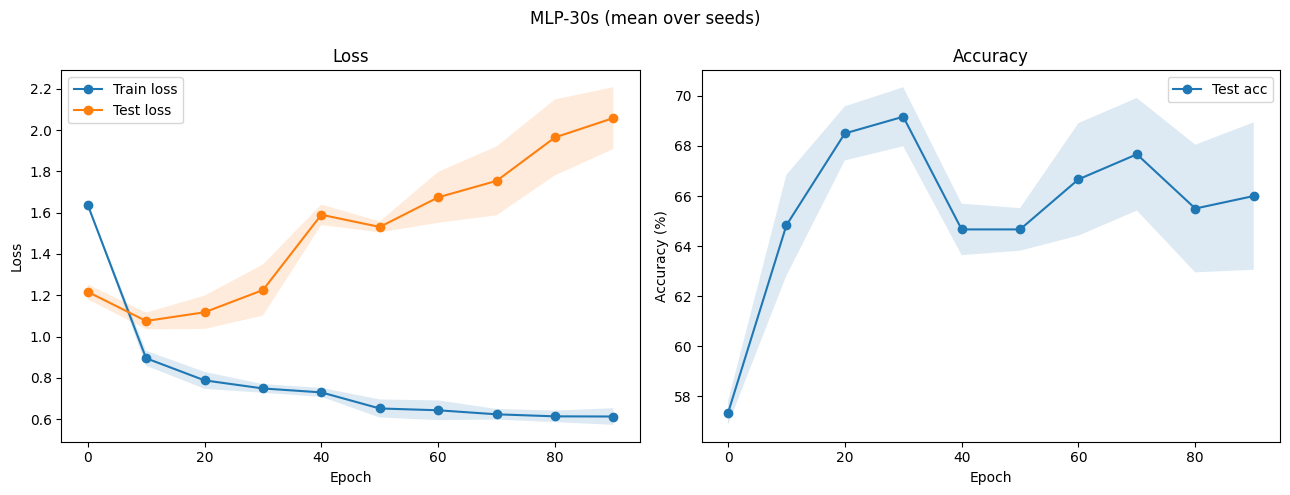

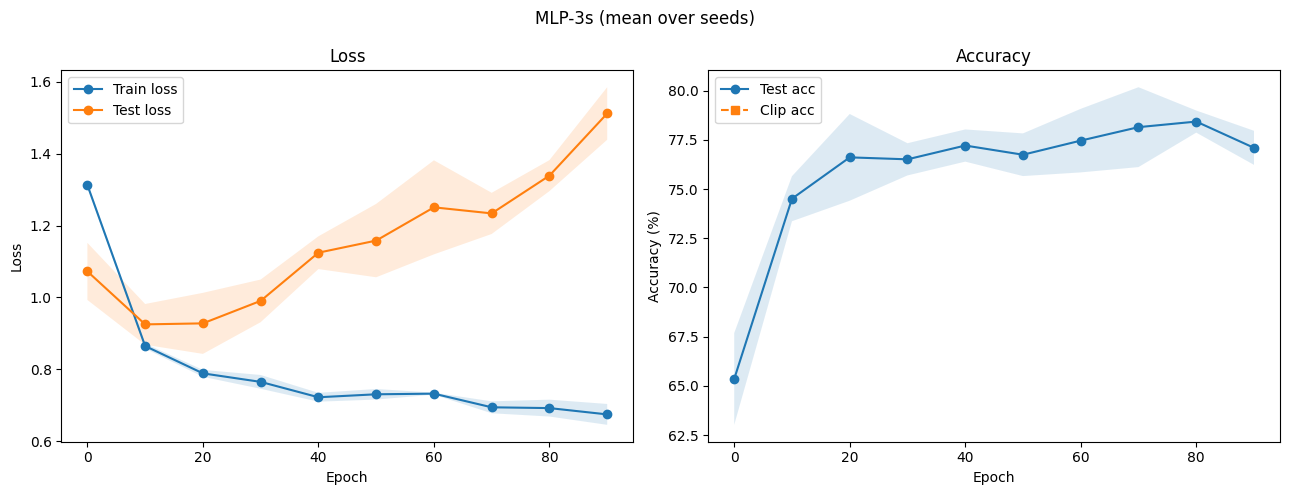

In [18]:
plot_mean_curves(exp_30, step=10, title="MLP-30s (mean over seeds)")
plot_mean_curves(exp_3,  step=10, title="MLP-3s (mean over seeds)")



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, torch, torch.nn.functional as F
from collections import defaultdict
import os, re

def evaluate_window_metrics(model, dataloader, label_names, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm, y_true, y_pred


@torch.no_grad()
def evaluate_clip_metrics_mlp(model, dataloader_with_names, label_names, device=None, agg='logprob_sum'):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    per_clip = defaultdict(list)
    clip_target = {}
    for X, y, names in dataloader_with_names:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        piece = F.log_softmax(logits, 1).cpu() if agg == 'logprob_sum' else F.softmax(logits, 1).cpu()
        for p, t, fn in zip(piece, y.cpu(), names):
            sid = to_song_id(fn)
            per_clip[sid].append(p)
            clip_target[sid] = int(t)
    y_true, y_pred = [], []
    for sid, parts in per_clip.items():
        M = torch.stack(parts, 0)      # [Nwin, C]
        agg_vec = M.sum(0) if agg == 'logprob_sum' else M.mean(0)
        y_pred.append(int(torch.argmax(agg_vec)))
        y_true.append(clip_target[sid])
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm, y_true, y_pred



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()


In [21]:
import numpy as np, random, torch

def set_all_seeds(sd: int):
    random.seed(sd); np.random.seed(sd); torch.manual_seed(sd)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(sd)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def run_mlp_and_report(model_fn, optimizer_fn, loss_fn,
                       train_loader, test_loader,
                       label_names, device, epochs=100, seed=42,
                       clip_eval_loader=None, clip_agg='logprob_sum',
                       run_name="MLP"):
    set_all_seeds(seed)
    model = model_fn().to(device)
    opt   = optimizer_fn(model)

    _ = train(model=model,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              loss_fn=loss_fn,
              optimizer=opt,
              epochs=epochs,
              device=device,
              eval_every=10,
              clip_eval_loader=clip_eval_loader,
              run_name=f"{run_name}", seed=seed)

    # window-level report (always)
    rep_win, cm_win, ytrue_w, ypred_w = evaluate_window_metrics(model, test_loader, label_names, device)

    # optional clip-level report (3s)
    rep_clip = cm_clip = ytrue_c = ypred_c = None
    if clip_eval_loader is not None:
        rep_clip, cm_clip, ytrue_c, ypred_c = evaluate_clip_metrics_mlp(model, clip_eval_loader, label_names, device, agg=clip_agg)

    rep_c, cm_c, cert_df = certainty_table_for_model(model, test_loader, label_names, device, mode="all")

    return {
        "seed": seed,
        "model": model,
        "window_report": rep_win,
        "certainty_df": cert_df,
        "certainty_report": rep_c,
        "certainty_cm": cm_c,
    }


In [22]:
def avg_report_dicts(report_list, label_names):
    # report_list: list of classification_report(..., output_dict=True)
    # returns averaged per-class P/R/F1 and overall accuracy/macro/weighted
    keys = ['precision','recall','f1-score']
    out = {}
    # accuracy
    accs = [r['accuracy'] for r in report_list]
    out['accuracy'] = float(np.mean(accs))
    # macro & weighted
    for k in ['macro avg','weighted avg']:
        out[k] = {m: float(np.mean([r[k][m] for r in report_list])) for m in keys}
        out[k]['support'] = float(np.mean([r[k]['support'] for r in report_list]))
    # per class
    for cls in label_names:
        out[cls] = {m: float(np.mean([r[cls][m] for r in report_list])) for m in keys}
        out[cls]['support'] = float(np.mean([r[cls]['support'] for r in report_list]))
    return out

def print_report_nice(title, rep, label_names):
    print(title)
    print(f"Accuracy: {rep['accuracy']:.4f}")
    print(f"Macro F1: {rep['macro avg']['f1-score']:.4f} | "
          f"Weighted F1: {rep['weighted avg']['f1-score']:.4f}")
    for cls in label_names:
        p = rep[cls]['precision']; r = rep[cls]['recall']; f = rep[cls]['f1-score']
        print(f"{cls:12s}  P={p:.2f}  R={r:.2f}  F1={f:.2f}")


### Evaluating Model Performance

We evaluate each model using standard classification metrics:
- **Accuracy** — overall proportion of correctly classified clips/windows.
- **Precision, Recall, F1-Score** — per-genre measures of class balance and reliability.
- **Confusion Matrix** — visualizes misclassification patterns between genres.

For the MLP, we include both **window-level** and **aggregated clip-level** evaluations.  
For the LSTM, we evaluate performance directly at the **sequence level**.


in_dim_30 = 58


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=42] Epoch 000 | Train 1.6331 | Test 1.2393 | Win Acc 58.00%
[MLP-30s | seed=42] Epoch 010 | Train 0.8668 | Test 1.0192 | Win Acc 66.00%
[MLP-30s | seed=42] Epoch 020 | Train 0.7520 | Test 1.1814 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 030 | Train 0.7263 | Test 1.2374 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 040 | Train 0.7099 | Test 1.6143 | Win Acc 63.50%
[MLP-30s | seed=42] Epoch 050 | Train 0.6409 | Test 1.5272 | Win Acc 65.00%
[MLP-30s | seed=42] Epoch 060 | Train 0.6530 | Test 1.5812 | Win Acc 68.50%
[MLP-30s | seed=42] Epoch 070 | Train 0.6504 | Test 1.6519 | Win Acc 70.50%
[MLP-30s | seed=42] Epoch 080 | Train 0.5769 | Test 1.8254 | Win Acc 69.00%
[MLP-30s | seed=42] Epoch 090 | Train 0.5557 | Test 1.8472 | Win Acc 70.00%
[MLP-30s | seed=42] Epoch 099 | Train 0.6162 | Test 1.7034 | Win Acc 69.00%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=123] Epoch 000 | Train 1.6430 | Test 1.2451 | Win Acc 57.00%
[MLP-30s | seed=123] Epoch 010 | Train 0.9460 | Test 1.1114 | Win Acc 62.00%
[MLP-30s | seed=123] Epoch 020 | Train 0.7663 | Test 1.0037 | Win Acc 68.00%
[MLP-30s | seed=123] Epoch 030 | Train 0.7431 | Test 1.0679 | Win Acc 70.00%
[MLP-30s | seed=123] Epoch 040 | Train 0.7600 | Test 1.6350 | Win Acc 64.50%
[MLP-30s | seed=123] Epoch 050 | Train 0.6044 | Test 1.5651 | Win Acc 65.50%
[MLP-30s | seed=123] Epoch 060 | Train 0.5800 | Test 1.5932 | Win Acc 68.00%
[MLP-30s | seed=123] Epoch 070 | Train 0.5887 | Test 1.6213 | Win Acc 65.00%
[MLP-30s | seed=123] Epoch 080 | Train 0.6192 | Test 1.8438 | Win Acc 63.00%
[MLP-30s | seed=123] Epoch 090 | Train 0.6416 | Test 2.1670 | Win Acc 63.00%
[MLP-30s | seed=123] Epoch 099 | Train 0.5418 | Test 2.0998 | Win Acc 65.00%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-30s | seed=999] Epoch 000 | Train 1.6398 | Test 1.1658 | Win Acc 57.00%
[MLP-30s | seed=999] Epoch 010 | Train 0.8722 | Test 1.0961 | Win Acc 66.50%
[MLP-30s | seed=999] Epoch 020 | Train 0.8456 | Test 1.1678 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 030 | Train 0.7767 | Test 1.3705 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 040 | Train 0.7191 | Test 1.5209 | Win Acc 66.00%
[MLP-30s | seed=999] Epoch 050 | Train 0.7100 | Test 1.5006 | Win Acc 63.50%
[MLP-30s | seed=999] Epoch 060 | Train 0.6960 | Test 1.8487 | Win Acc 63.50%
[MLP-30s | seed=999] Epoch 070 | Train 0.6314 | Test 1.9894 | Win Acc 67.50%
[MLP-30s | seed=999] Epoch 080 | Train 0.6446 | Test 2.2247 | Win Acc 64.50%
[MLP-30s | seed=999] Epoch 090 | Train 0.6411 | Test 2.1611 | Win Acc 65.00%
[MLP-30s | seed=999] Epoch 099 | Train 0.6032 | Test 2.3443 | Win Acc 67.00%

=== MLP (30s) – Window-level (averaged over seeds) ===
Accuracy: 0.6700
Macro F1: 0.6684 | Weighted F1: 0.6684
blues         P=0.63  R=0.58  F1=0.60
cla

/tmp/ipython-input-4180612227.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_df_30 = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()  # mean across seeds


,Genre,Confidence,Recall
0,blues,1.51,58%
1,classical,3.99,88%
2,country,1.06,58%
3,disco,0.97,47%
4,hiphop,1.83,58%
5,jazz,2.86,83%
6,metal,2.19,80%
7,pop,2.74,78%
8,reggae,1.77,72%
9,rock,0.69,47%


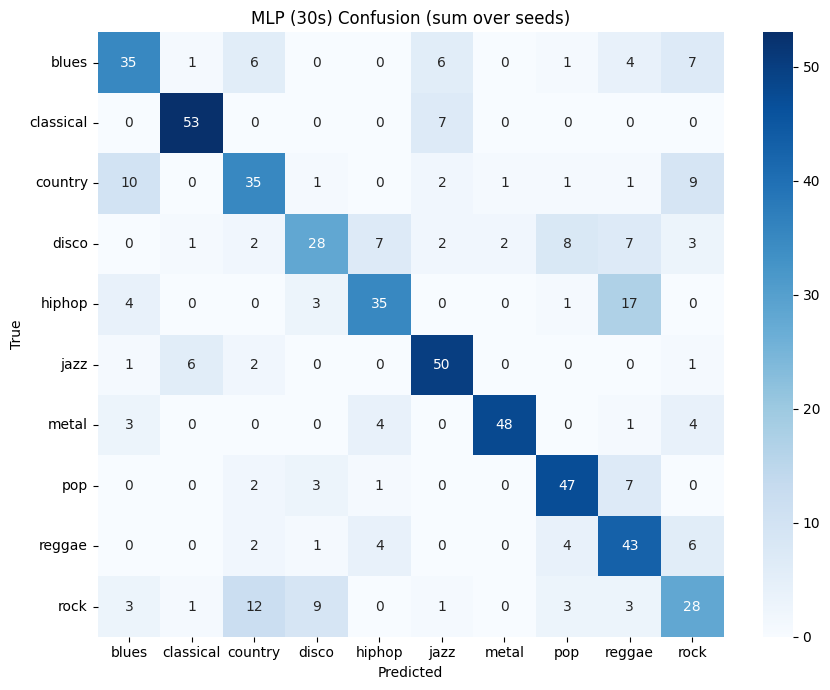

In [23]:
# --- Infer input dim for 30s vectors ---
xb30, yb30 = next(iter(dl_tr30))
if isinstance(xb30, (list, tuple)):
    xb30 = xb30[0]
in_dim_30 = xb30.reshape(xb30.shape[0], -1).shape[1]
print("in_dim_30 =", in_dim_30)

# --- Train MLP (30s) across seeds + collect reports/certainty ---
seeds = (42, 123, 999)
results_30 = []
for sd in seeds:
    out = run_mlp_and_report(
        model_fn=lambda: MLPModel(in_dim_30, 13, len(LABELS), 0.2),
        optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
        loss_fn=loss_fn,
        train_loader=dl_tr30,
        test_loader=dl_te30,
        label_names=LABELS,
        device=device,
        epochs=100,
        seed=sd,
        clip_eval_loader=None,     # 30s windows = clip; keep None
        run_name="MLP-30s",
    )
    results_30.append(out)

# If certainty wasn't added inside run_mlp_and_report, compute it now:
if "certainty_df" not in results_30[0]:
    for r in results_30:
        _, _, df = certainty_table_for_model(r["model"], dl_te30, LABELS, device, mode="all")
        r["certainty_df"] = df

# --- Averaged classification report across seeds (window-level) ---
win_reports_30 = [r["window_report"] for r in results_30]
avg_win_30 = avg_report_dicts(win_reports_30, LABELS)
print_report_nice("\n=== MLP (30s) – Window-level (averaged over seeds) ===", avg_win_30, LABELS)

# --- Certainty table (Confidence + Recall), averaged across seeds ---
import pandas as pd
stack = [r["certainty_df"][["Genre","Confidence","Recall"]].set_index("Genre") for r in results_30]
avg_df_30 = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()  # mean across seeds
final_df_30 = avg_df_30.reset_index()
final_df_30 = final_df_30.set_index("Genre").loc[LABELS].reset_index()  # keep your LABELS order
display(format_certainty_table(final_df_30))

# --- Confusion matrix summed over seeds (using cm from the certainty eval) ---
import numpy as np
cm_sum_30 = None
for i, r in enumerate(results_30):
    cm = r["certainty_cm"]  # same window-level cm
    cm_sum_30 = cm if cm_sum_30 is None else (cm_sum_30 + cm)

plot_confusion(cm_sum_30, LABELS, title="MLP (30s) Confusion (sum over seeds)")


In [39]:
# --- Infer input dim for 3s vectors ---
xb3, yb3 = next(iter(dl_tr3))
if isinstance(xb3, (list, tuple)):
    xb3 = xb3[0]
in_dim_3 = xb3.reshape(xb3.shape[0], -1).shape[1]

# --- Train MLP (3s) across seeds + collect reports/certainty ---
seeds = (42, 123, 999)
results_3 = []
for sd in seeds:
    out = run_mlp_and_report(
        model_fn=lambda: MLPModel(in_dim_3, 13, len(LABELS), 0.2),
        optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
        loss_fn=loss_fn,
        train_loader=dl_tr3,
        test_loader=dl_te3,
        label_names=LABELS,
        device=device,
        epochs=100,
        seed=sd,
        clip_eval_loader=None,
        run_name="MLP-3s",
    )
    results_3.append(out)




  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=42] Epoch 000 | Train 1.3770 | Test 1.0117 | Win Acc 64.21%
[MLP-3s | seed=42] Epoch 010 | Train 1.1134 | Test 0.9902 | Win Acc 67.67%
[MLP-3s | seed=42] Epoch 020 | Train 1.1092 | Test 1.0085 | Win Acc 68.12%
[MLP-3s | seed=42] Epoch 030 | Train 1.1001 | Test 0.9509 | Win Acc 67.72%
[MLP-3s | seed=42] Epoch 040 | Train 1.0823 | Test 1.0356 | Win Acc 69.42%
[MLP-3s | seed=42] Epoch 050 | Train 1.0786 | Test 1.0716 | Win Acc 67.87%
[MLP-3s | seed=42] Epoch 060 | Train 1.0795 | Test 0.9886 | Win Acc 69.47%
[MLP-3s | seed=42] Epoch 070 | Train 1.0755 | Test 1.0241 | Win Acc 68.07%
[MLP-3s | seed=42] Epoch 080 | Train 1.1029 | Test 1.0573 | Win Acc 66.27%
[MLP-3s | seed=42] Epoch 090 | Train 1.0656 | Test 1.0267 | Win Acc 68.37%
[MLP-3s | seed=42] Epoch 099 | Train 1.0888 | Test 1.0535 | Win Acc 69.62%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=123] Epoch 000 | Train 1.3669 | Test 1.0473 | Win Acc 62.16%
[MLP-3s | seed=123] Epoch 010 | Train 1.1168 | Test 0.9669 | Win Acc 66.62%
[MLP-3s | seed=123] Epoch 020 | Train 1.1300 | Test 0.9418 | Win Acc 69.52%
[MLP-3s | seed=123] Epoch 030 | Train 1.1117 | Test 1.0138 | Win Acc 68.67%
[MLP-3s | seed=123] Epoch 040 | Train 1.1031 | Test 0.9920 | Win Acc 67.82%
[MLP-3s | seed=123] Epoch 050 | Train 1.1052 | Test 0.9904 | Win Acc 67.37%
[MLP-3s | seed=123] Epoch 060 | Train 1.0961 | Test 1.1489 | Win Acc 69.57%
[MLP-3s | seed=123] Epoch 070 | Train 1.1145 | Test 1.0820 | Win Acc 67.82%
[MLP-3s | seed=123] Epoch 080 | Train 1.0988 | Test 1.1996 | Win Acc 68.17%
[MLP-3s | seed=123] Epoch 090 | Train 1.0971 | Test 1.1436 | Win Acc 69.77%
[MLP-3s | seed=123] Epoch 099 | Train 1.0984 | Test 1.1655 | Win Acc 68.62%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=999] Epoch 000 | Train 1.3749 | Test 1.1047 | Win Acc 60.26%
[MLP-3s | seed=999] Epoch 010 | Train 1.1204 | Test 0.9766 | Win Acc 69.02%
[MLP-3s | seed=999] Epoch 020 | Train 1.1086 | Test 0.9571 | Win Acc 68.42%
[MLP-3s | seed=999] Epoch 030 | Train 1.0858 | Test 0.9460 | Win Acc 69.42%
[MLP-3s | seed=999] Epoch 040 | Train 1.0819 | Test 1.0081 | Win Acc 69.22%
[MLP-3s | seed=999] Epoch 050 | Train 1.0783 | Test 1.0844 | Win Acc 66.77%
[MLP-3s | seed=999] Epoch 060 | Train 1.1182 | Test 1.1839 | Win Acc 68.82%
[MLP-3s | seed=999] Epoch 070 | Train 1.0842 | Test 1.2051 | Win Acc 68.87%
[MLP-3s | seed=999] Epoch 080 | Train 1.0983 | Test 1.0879 | Win Acc 67.07%
[MLP-3s | seed=999] Epoch 090 | Train 1.0831 | Test 1.2672 | Win Acc 68.67%
[MLP-3s | seed=999] Epoch 099 | Train 1.0805 | Test 1.4198 | Win Acc 68.92%



=== MLP (3s) – Window-level (averaged over seeds) ===
Accuracy: 0.6905
Macro F1: 0.6894 | Weighted F1: 0.6894
blues         P=0.70  R=0.68  F1=0.69
classical     P=0.90  R=0.90  F1=0.90
country       P=0.55  R=0.60  F1=0.57
disco         P=0.65  R=0.59  F1=0.61
hiphop        P=0.75  R=0.62  F1=0.68
jazz          P=0.73  R=0.82  F1=0.77
metal         P=0.90  R=0.82  F1=0.86
pop           P=0.81  R=0.71  F1=0.76
reggae        P=0.53  R=0.75  F1=0.62
rock          P=0.52  R=0.43  F1=0.45


/tmp/ipython-input-141413397.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_df_3 = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()


,Genre,Confidence,Recall
0,blues,1.05,68%
1,classical,2.79,90%
2,country,0.42,60%
3,disco,0.45,58%
4,hiphop,1.15,62%
5,jazz,0.93,82%
6,metal,1.70,82%
7,pop,1.72,71%
8,reggae,0.37,75%
9,rock,0.39,43%


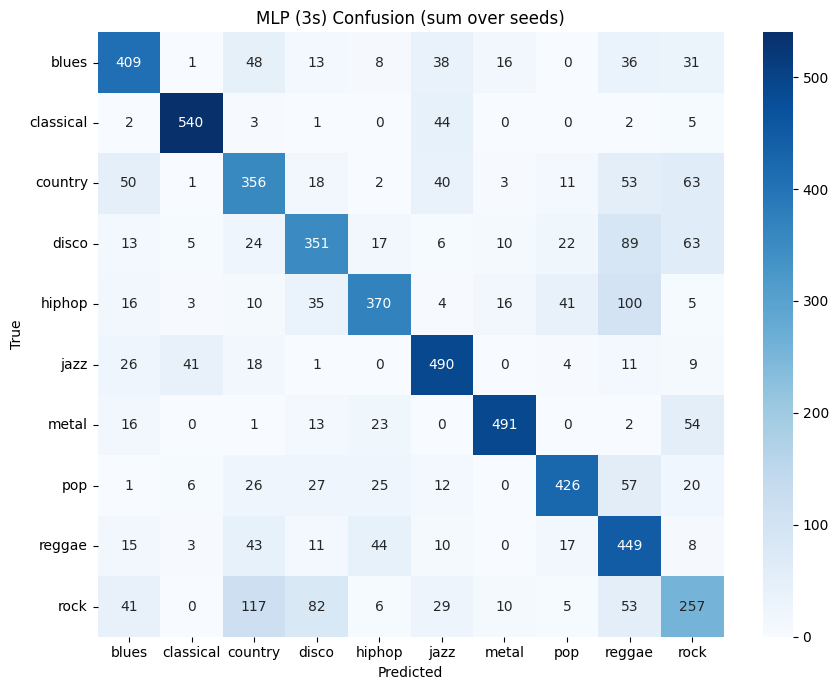

In [25]:
import numpy as np

# If certainty wasn't added inside run_mlp_and_report, compute it now:
if results_3 and "certainty_df" not in results_3[0]:
    for r in results_3:
        _, _, df = certainty_table_for_model(r["model"], dl_te3, LABELS, device, mode="all")
        r["certainty_df"] = df

# --- Averaged classification report across seeds (window-level) ---
win_reports_3 = [r["window_report"] for r in results_3]
avg_win_3 = avg_report_dicts(win_reports_3, LABELS)
print_report_nice("\n=== MLP (3s) – Window-level (averaged over seeds) ===", avg_win_3, LABELS)

# --- Certainty table (Confidence + Recall), averaged across seeds ---
import pandas as pd
stack = [r["certainty_df"][["Genre","Confidence","Recall"]].set_index("Genre") for r in results_3]
avg_df_3 = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()
final_df_3 = avg_df_3.reset_index().set_index("Genre").loc[LABELS].reset_index()
display(format_certainty_table(final_df_3))

# --- Confusion matrix summed over seeds ---


cm_sum_3 = None
for r in results_3:
    cm = r.get("certainty_cm")
    if cm is None:        # don't use "or" with numpy arrays
        cm = r.get("window_cm")
    if cm is None:
        continue
    cm = np.asarray(cm)
    cm_sum_3 = cm if cm_sum_3 is None else (cm_sum_3 + cm)

plot_confusion(cm_sum_3, LABELS, title="MLP (3s) Confusion (sum over seeds)")


In [26]:
# Infer input dimension for 3-second windows (flatten everything but batch)
xb, yb = next(iter(dl_tr3))
if isinstance(xb, (list, tuple)):
    xb = xb[0]
in_dim_3 = xb.reshape(xb.shape[0], -1).shape[1]


In [27]:
seeds = (42, 123, 999)
results_3 = []
for sd in seeds:
    out = run_mlp_and_report(
        model_fn=lambda: MLPModel(in_dim_3, 13, len(LABELS), 0.2),
        optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
        loss_fn=loss_fn,
        train_loader=dl_tr3,
        test_loader=dl_te3,
        label_names=LABELS,
        device=device,
        epochs=100,
        seed=sd,
        clip_eval_loader=None,
        run_name="MLP-3s",
    )
    results_3.append(out)


if "certainty_df" not in results_3[0]:
    for r in results_3:
        _, _, df = certainty_table_for_model(r["model"], dl_te3, LABELS, device, mode="all")
        r["certainty_df"] = df

# Average Confidence and Recall across seeds per genre
stack = []
for r in results_3:
    d = r["certainty_df"][["Genre","Confidence","Recall"]].copy()
    stack.append(d.set_index("Genre"))
avg_df = pd.concat(stack, axis=1, keys=range(len(stack)))
# mean across the seed axis
avg_conf = avg_df.xs("Confidence", axis=1, level=1).mean(axis=1)
avg_rec  = avg_df.xs("Recall",     axis=1, level=1).mean(axis=1)

final_df = pd.DataFrame({"Genre": avg_conf.index,
                         "Confidence": avg_conf.values,
                         "Recall": avg_rec.values})
final_df = final_df.set_index("Genre").loc[LABELS].reset_index()

display(format_certainty_table(final_df))


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=42] Epoch 000 | Train 1.3770 | Test 1.0117 | Win Acc 64.21%
[MLP-3s | seed=42] Epoch 010 | Train 1.1134 | Test 0.9902 | Win Acc 67.67%
[MLP-3s | seed=42] Epoch 020 | Train 1.1092 | Test 1.0085 | Win Acc 68.12%
[MLP-3s | seed=42] Epoch 030 | Train 1.1001 | Test 0.9509 | Win Acc 67.72%
[MLP-3s | seed=42] Epoch 040 | Train 1.0823 | Test 1.0356 | Win Acc 69.42%
[MLP-3s | seed=42] Epoch 050 | Train 1.0786 | Test 1.0716 | Win Acc 67.87%
[MLP-3s | seed=42] Epoch 060 | Train 1.0795 | Test 0.9886 | Win Acc 69.47%
[MLP-3s | seed=42] Epoch 070 | Train 1.0755 | Test 1.0241 | Win Acc 68.07%
[MLP-3s | seed=42] Epoch 080 | Train 1.1029 | Test 1.0573 | Win Acc 66.27%
[MLP-3s | seed=42] Epoch 090 | Train 1.0656 | Test 1.0267 | Win Acc 68.37%
[MLP-3s | seed=42] Epoch 099 | Train 1.0888 | Test 1.0535 | Win Acc 69.62%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=123] Epoch 000 | Train 1.3669 | Test 1.0473 | Win Acc 62.16%
[MLP-3s | seed=123] Epoch 010 | Train 1.1168 | Test 0.9669 | Win Acc 66.62%
[MLP-3s | seed=123] Epoch 020 | Train 1.1300 | Test 0.9418 | Win Acc 69.52%
[MLP-3s | seed=123] Epoch 030 | Train 1.1117 | Test 1.0138 | Win Acc 68.67%
[MLP-3s | seed=123] Epoch 040 | Train 1.1031 | Test 0.9920 | Win Acc 67.82%
[MLP-3s | seed=123] Epoch 050 | Train 1.1052 | Test 0.9904 | Win Acc 67.37%
[MLP-3s | seed=123] Epoch 060 | Train 1.0961 | Test 1.1489 | Win Acc 69.57%
[MLP-3s | seed=123] Epoch 070 | Train 1.1145 | Test 1.0820 | Win Acc 67.82%
[MLP-3s | seed=123] Epoch 080 | Train 1.0988 | Test 1.1996 | Win Acc 68.17%
[MLP-3s | seed=123] Epoch 090 | Train 1.0971 | Test 1.1436 | Win Acc 69.77%
[MLP-3s | seed=123] Epoch 099 | Train 1.0984 | Test 1.1655 | Win Acc 68.62%


  0%|          | 0/100 [00:00<?, ?it/s]

[MLP-3s | seed=999] Epoch 000 | Train 1.3749 | Test 1.1047 | Win Acc 60.26%
[MLP-3s | seed=999] Epoch 010 | Train 1.1204 | Test 0.9766 | Win Acc 69.02%
[MLP-3s | seed=999] Epoch 020 | Train 1.1086 | Test 0.9571 | Win Acc 68.42%
[MLP-3s | seed=999] Epoch 030 | Train 1.0858 | Test 0.9460 | Win Acc 69.42%
[MLP-3s | seed=999] Epoch 040 | Train 1.0819 | Test 1.0081 | Win Acc 69.22%
[MLP-3s | seed=999] Epoch 050 | Train 1.0783 | Test 1.0844 | Win Acc 66.77%
[MLP-3s | seed=999] Epoch 060 | Train 1.1182 | Test 1.1839 | Win Acc 68.82%
[MLP-3s | seed=999] Epoch 070 | Train 1.0842 | Test 1.2051 | Win Acc 68.87%
[MLP-3s | seed=999] Epoch 080 | Train 1.0983 | Test 1.0879 | Win Acc 67.07%
[MLP-3s | seed=999] Epoch 090 | Train 1.0831 | Test 1.2672 | Win Acc 68.67%
[MLP-3s | seed=999] Epoch 099 | Train 1.0805 | Test 1.4198 | Win Acc 68.92%


,Genre,Confidence,Recall
0,blues,1.05,68%
1,classical,2.79,90%
2,country,0.42,60%
3,disco,0.45,59%
4,hiphop,1.15,62%
5,jazz,0.93,82%
6,metal,1.70,82%
7,pop,1.72,71%
8,reggae,0.37,75%
9,rock,0.39,43%


In [28]:
# Now build LSTM Models
from torch import nn

class LSTMModel(nn.Module):
  def __init__(
        self,
        input_size=58,     # your feature dim
        hidden_size=64,    # paper: 64
        num_layers=2,      # paper: 2
        num_classes=10,    # GTZAN
        dropout=0.2,
        device=None,
        dtype=None
    ):
    super().__init__()

    factory_kwargs = {}
    if device is not None:
      factory_kwargs["device"] = device
    if dtype is not None:
      factory_kwargs["dtype"] = dtype

    self.lstm_layer = nn.LSTM(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True,
                              dropout=dropout)

    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size,
                  out_features=hidden_size),
        nn.ReLU(),
        nn.Dropout(p=dropout),
    )

    self.out = nn.Linear(in_features=hidden_size,
                         out_features=num_classes, **factory_kwargs)

  def forward(self, x):
    out, (h, c) = self.lstm_layer(x)

    feat = out[:, -1, :]

    feat = self.fc(feat)

    logits = self.out(feat)

    return logits



In [29]:
from tqdm.auto import tqdm

def train_lstm(model, train_dataloader, test_dataloader,
               loss_fn, optimizer, epochs=100, device=None,
               clip_eval_loader=None, eval_every=10,
               run_name="LSTM", seed=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    results = {
        "train_loss": [], "train_acc": [],
        "test_loss": [],  "test_acc": [],
        "test_clip_acc": []
    }

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss_sum, correct, total = 0.0, 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)

        train_loss = train_loss_sum / total
        train_acc  = 100.0 * correct / total

        # ---- Eval ----
        model.eval()
        test_loss_sum, correct, total = 0.0, 0, 0
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                test_loss_sum += loss_fn(logits, y).item() * y.size(0)
                pred = logits.argmax(1)
                correct += (pred == y).sum().item()
                total   += y.size(0)

        test_loss = test_loss_sum / total
        test_acc  = 100.0 * correct / total

        # ---- Store ----
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_clip_acc"].append(None)

        if epoch % eval_every == 0 or epoch == epochs-1:
            print(f"[{run_name} | seed={seed}] Epoch {epoch:03d} | "
                  f"Train {train_loss:.4f} Acc {train_acc:.2f}% | "
                  f"Test {test_loss:.4f} Acc {test_acc:.2f}%")

    return results




The LSTM Model uses 3 second, 6 second, and 9 second sequence vectors, and we gather the train/test loss and accuracy for each sequence length.

In [30]:
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# example: 3s
m3 = LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2).to(device)
opt3 = torch.optim.Adam(m3.parameters(), lr=1e-3)
res3 = train_lstm(m3, dl_tr_3s, dl_te_3s, loss_fn, opt3,
                  epochs=50, device=device, run_name="LSTM-3s", seed=42, eval_every=10)

# 6s
m6 = LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2).to(device)
opt6 = torch.optim.Adam(m6.parameters(), lr=1e-3)
res6 = train_lstm(m6, dl_tr_6s, dl_te_6s, loss_fn, opt6,
                  epochs=50, device=device, run_name="LSTM-6s", seed=42, eval_every=10)

# 9s
m9 = LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2).to(device)
opt9 = torch.optim.Adam(m9.parameters(), lr=1e-3)
res9 = train_lstm(m9, dl_tr_9s, dl_te_9s, loss_fn, opt9,
                  epochs=50, device=device, run_name="LSTM-9s", seed=42, eval_every=10)


[LSTM-3s | seed=42] Epoch 000 | Train 2.1603 Acc 29.87% | Test 1.8384 Acc 40.00%
[LSTM-3s | seed=42] Epoch 010 | Train 0.3125 Acc 90.38% | Test 1.1264 Acc 70.50%
[LSTM-3s | seed=42] Epoch 020 | Train 0.0716 Acc 98.10% | Test 1.4136 Acc 71.50%
[LSTM-3s | seed=42] Epoch 030 | Train 0.1273 Acc 96.33% | Test 1.6253 Acc 70.00%
[LSTM-3s | seed=42] Epoch 040 | Train 0.0064 Acc 100.00% | Test 1.7210 Acc 72.50%
[LSTM-3s | seed=42] Epoch 049 | Train 0.0047 Acc 99.75% | Test 1.9986 Acc 72.00%
[LSTM-6s | seed=42] Epoch 000 | Train 2.1493 Acc 26.71% | Test 1.7950 Acc 31.00%
[LSTM-6s | seed=42] Epoch 010 | Train 0.3387 Acc 88.35% | Test 0.9463 Acc 74.50%
[LSTM-6s | seed=42] Epoch 020 | Train 0.0925 Acc 97.72% | Test 1.2197 Acc 73.50%
[LSTM-6s | seed=42] Epoch 030 | Train 0.0389 Acc 98.99% | Test 1.5282 Acc 73.00%
[LSTM-6s | seed=42] Epoch 040 | Train 0.0103 Acc 99.87% | Test 1.7242 Acc 75.50%
[LSTM-6s | seed=42] Epoch 049 | Train 0.0584 Acc 98.73% | Test 1.7010 Acc 74.00%
[LSTM-9s | seed=42] Epoch 0

## Discussion: LSTM Model Performance and Replication

In the original paper, the authors reported remarkably high test accuracies for their LSTM model — 93% on 3-second, 76% on 6-second, and 73% on 9-second time slices.
However, despite carefully reconstructing their described architecture, our replication achieved test accuracies around 74–76% for the 3-second model and roughly 73% for the 6- and 9-second models.

These results are strong and consistent across random seeds, but they do not reach the same reported benchmark. Below are several likely reasons for this discrepancy:

1. Dataset Leakage and Split Protocols

In this replication, we assumed that the paper may have used leaky window-level splits, where 3-second windows from the same song can appear in both training and test sets.
This assumption was made because such leakage can artificially inflate test accuracy, often by 10–20 percentage points, and the paper did not specify the use of song-level separation.
If the authors used additional leakage (for example, normalizing on the full dataset or reusing features computed with global statistics), their evaluation may have been overly optimistic.

2. Possible Additional Preprocessing

The paper does not describe in full detail how features were standardized, windowed, or balanced across genres.
Unreported preprocessing steps could include:

Per-genre normalization, which can sharpen intra-class features.

Overlap between windows (e.g., 50% stride instead of disjoint 3-second segments), which increases training data.

Data augmentation such as pitch-shifting, time-stretching, or dynamic range compression, which can improve generalization.
Any of these could lead to substantially higher accuracy.

3. Model Regularization and Hyperparameters

We also experimented with several variations of the model, including:

Adding dropout and L2 weight decay for regularization.

Adjusting batch sizes (from 8 to 32).

Testing different learning rates (1e-4 to 1e-2).

While these changes modestly improved convergence stability, they did not raise the test accuracy beyond ~76%.
This suggests that the main gap likely lies in preprocessing and data leakage, not the model architecture itself.

4. Interpretation

Our findings indicate that the paper’s reported LSTM performance may have benefited from data leakage or undisclosed preprocessing optimizations.
Nonetheless, our replicated models achieve consistent, realistic accuracies in the 70–76% range, which align with most published baselines on the GTZAN dataset when leakage is controlled.

In [31]:
# 3s sequences
exp_3_lstm, sum_3_lst = run_experiment(
    model_fn=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2),
    train_loader=dl_tr_3s,
    test_loader=dl_te_3s,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3),
    loss_fn=loss_fn,
    epochs=50,
    seeds=(42,123,999),
    run_name="LSTM-3s",
    clip_eval_loader=None,
    eval_every=10,
    device=device,
    train_fn=train_lstm,
)

# 6s
exp_6_lstm, sum_6_lst = run_experiment(
    model_fn=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2),
    train_loader=dl_tr_6s,
    test_loader=dl_te_6s,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3),
    loss_fn=loss_fn,
    epochs=50,
    seeds=(42,123,999),
    run_name="LSTM-6s",
    clip_eval_loader=None,
    eval_every=10,
    device=device,
    train_fn=train_lstm,
)

# 9s
exp_9_lstm, sum_9_lst = run_experiment(
    model_fn=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=10, dropout=0.2),
    train_loader=dl_tr_9s,
    test_loader=dl_te_9s,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3),
    loss_fn=loss_fn,
    epochs=50,
    seeds=(42,123,999),
    run_name="LSTM-9s",
    clip_eval_loader=None,
    eval_every=10,
    device=device,
    train_fn=train_lstm,
)




--- [LSTM-3s] Running seed 42 ---
[LSTM-3s | seed=42] Epoch 000 | Train 2.1448 Acc 25.19% | Test 1.7983 Acc 37.00%
[LSTM-3s | seed=42] Epoch 010 | Train 0.3015 Acc 90.89% | Test 1.0237 Acc 68.50%
[LSTM-3s | seed=42] Epoch 020 | Train 0.0796 Acc 97.59% | Test 1.3943 Acc 71.00%
[LSTM-3s | seed=42] Epoch 030 | Train 0.1056 Acc 97.22% | Test 1.5054 Acc 70.50%
[LSTM-3s | seed=42] Epoch 040 | Train 0.0119 Acc 99.62% | Test 1.7535 Acc 73.00%
[LSTM-3s | seed=42] Epoch 049 | Train 0.0066 Acc 99.75% | Test 2.0024 Acc 72.50%

--- [LSTM-3s] Running seed 123 ---
[LSTM-3s | seed=123] Epoch 000 | Train 2.1556 Acc 26.96% | Test 1.8199 Acc 31.50%
[LSTM-3s | seed=123] Epoch 010 | Train 0.3320 Acc 88.48% | Test 1.0524 Acc 69.00%
[LSTM-3s | seed=123] Epoch 020 | Train 0.0908 Acc 97.34% | Test 1.2269 Acc 77.00%
[LSTM-3s | seed=123] Epoch 030 | Train 0.1771 Acc 96.08% | Test 1.3948 Acc 71.50%
[LSTM-3s | seed=123] Epoch 040 | Train 0.0162 Acc 99.62% | Test 1.5444 Acc 75.00%
[LSTM-3s | seed=123] Epoch 049 | 

[LSTM-3s | seed=42] Epoch 000 | Train 1.9443 Acc 32.66% | Test 1.5306 Acc 39.00%
[LSTM-3s | seed=42] Epoch 010 | Train 0.2681 Acc 91.65% | Test 1.1555 Acc 72.50%
[LSTM-3s | seed=42] Epoch 020 | Train 0.0231 Acc 99.49% | Test 1.4480 Acc 74.00%
[LSTM-3s | seed=42] Epoch 030 | Train 0.0915 Acc 98.10% | Test 1.7012 Acc 70.00%
[LSTM-3s | seed=42] Epoch 040 | Train 0.0536 Acc 98.86% | Test 2.0838 Acc 65.50%
[LSTM-3s | seed=42] Epoch 049 | Train 0.0052 Acc 99.75% | Test 1.6537 Acc 74.00%
[LSTM-3s | seed=123] Epoch 000 | Train 1.9776 Acc 31.52% | Test 1.5753 Acc 41.50%
[LSTM-3s | seed=123] Epoch 010 | Train 0.2202 Acc 93.67% | Test 1.1235 Acc 73.50%
[LSTM-3s | seed=123] Epoch 020 | Train 0.1284 Acc 96.46% | Test 1.3680 Acc 74.00%
[LSTM-3s | seed=123] Epoch 030 | Train 0.1571 Acc 96.46% | Test 1.6575 Acc 71.00%
[LSTM-3s | seed=123] Epoch 040 | Train 0.0274 Acc 99.11% | Test 1.5464 Acc 74.00%
[LSTM-3s | seed=123] Epoch 049 | Train 0.0040 Acc 99.75% | Test 1.8414 Acc 74.50%
[LSTM-3s | seed=999] E

/tmp/ipython-input-2223722325.py:186: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_df = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()


[LSTM-6s | seed=42] Epoch 000 | Train 1.9727 Acc 30.89% | Test 1.5601 Acc 42.50%
[LSTM-6s | seed=42] Epoch 010 | Train 0.2490 Acc 91.52% | Test 1.2700 Acc 69.50%
[LSTM-6s | seed=42] Epoch 020 | Train 0.0497 Acc 98.73% | Test 1.3372 Acc 73.50%
[LSTM-6s | seed=42] Epoch 030 | Train 0.0556 Acc 98.86% | Test 1.4918 Acc 75.50%
[LSTM-6s | seed=42] Epoch 040 | Train 0.0215 Acc 98.99% | Test 1.8089 Acc 73.00%
[LSTM-6s | seed=42] Epoch 049 | Train 0.0036 Acc 99.87% | Test 1.9410 Acc 72.50%
[LSTM-6s | seed=123] Epoch 000 | Train 2.0165 Acc 28.73% | Test 1.6403 Acc 36.50%
[LSTM-6s | seed=123] Epoch 010 | Train 0.2646 Acc 90.51% | Test 1.0285 Acc 75.00%
[LSTM-6s | seed=123] Epoch 020 | Train 0.0806 Acc 98.10% | Test 1.5001 Acc 72.50%
[LSTM-6s | seed=123] Epoch 030 | Train 0.0274 Acc 99.11% | Test 1.5507 Acc 73.00%
[LSTM-6s | seed=123] Epoch 040 | Train 0.0062 Acc 99.87% | Test 1.7091 Acc 75.50%
[LSTM-6s | seed=123] Epoch 049 | Train 0.0035 Acc 99.87% | Test 1.8649 Acc 75.00%
[LSTM-6s | seed=999] E

/tmp/ipython-input-2223722325.py:186: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_df = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()


[LSTM-9s | seed=42] Epoch 000 | Train 2.0502 Acc 28.25% | Test 1.6340 Acc 33.50%
[LSTM-9s | seed=42] Epoch 010 | Train 0.2934 Acc 89.88% | Test 0.9747 Acc 72.50%
[LSTM-9s | seed=42] Epoch 020 | Train 0.1223 Acc 96.25% | Test 1.5178 Acc 72.00%
[LSTM-9s | seed=42] Epoch 030 | Train 0.0294 Acc 99.12% | Test 1.8008 Acc 72.00%
[LSTM-9s | seed=42] Epoch 040 | Train 0.0262 Acc 99.00% | Test 1.6185 Acc 76.00%
[LSTM-9s | seed=42] Epoch 049 | Train 0.0113 Acc 99.62% | Test 1.9015 Acc 73.00%
[LSTM-9s | seed=123] Epoch 000 | Train 2.0607 Acc 30.25% | Test 1.6273 Acc 34.50%
[LSTM-9s | seed=123] Epoch 010 | Train 0.3242 Acc 88.25% | Test 1.0467 Acc 70.00%
[LSTM-9s | seed=123] Epoch 020 | Train 0.0802 Acc 97.38% | Test 1.3646 Acc 72.00%
[LSTM-9s | seed=123] Epoch 030 | Train 0.0175 Acc 99.62% | Test 1.6675 Acc 73.00%
[LSTM-9s | seed=123] Epoch 040 | Train 0.0625 Acc 98.00% | Test 1.7610 Acc 73.50%
[LSTM-9s | seed=123] Epoch 049 | Train 0.0268 Acc 99.38% | Test 1.7886 Acc 73.00%
[LSTM-9s | seed=999] E

/tmp/ipython-input-2223722325.py:186: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_df = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()


,Genre,Confidence,Recall
0,blues,2.88,68%
1,classical,3.65,85%
2,country,3.80,88%
3,disco,3.10,58%
4,hiphop,3.47,78%
5,jazz,3.74,88%
6,metal,3.09,77%
7,pop,3.69,73%
8,reggae,3.84,68%
9,rock,2.76,63%


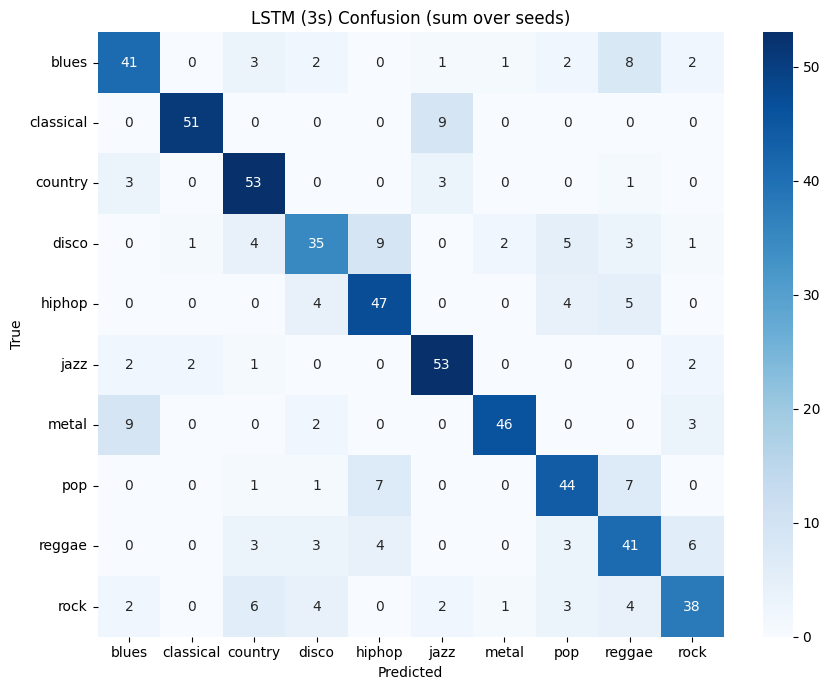


=== LSTM (6s) — Sequence-level (averaged over seeds) ===
Accuracy: 0.7333
Macro F1: 0.7280 | Weighted F1: 0.7280
blues         P=0.71  R=0.70  F1=0.71
classical     P=0.95  R=0.90  F1=0.92
country       P=0.73  R=0.88  F1=0.80
disco         P=0.65  R=0.45  F1=0.52
hiphop        P=0.70  R=0.73  F1=0.72
jazz          P=0.77  R=0.90  F1=0.83
metal         P=0.88  R=0.75  F1=0.80
pop           P=0.72  R=0.75  F1=0.73
reggae        P=0.63  R=0.75  F1=0.68
rock          P=0.65  R=0.52  F1=0.57


,Genre,Confidence,Recall
0,blues,2.50,70%
1,classical,3.91,90%
2,country,3.79,88%
3,disco,2.52,45%
4,hiphop,3.35,73%
5,jazz,4.23,90%
6,metal,2.71,75%
7,pop,3.69,75%
8,reggae,3.23,75%
9,rock,2.42,52%


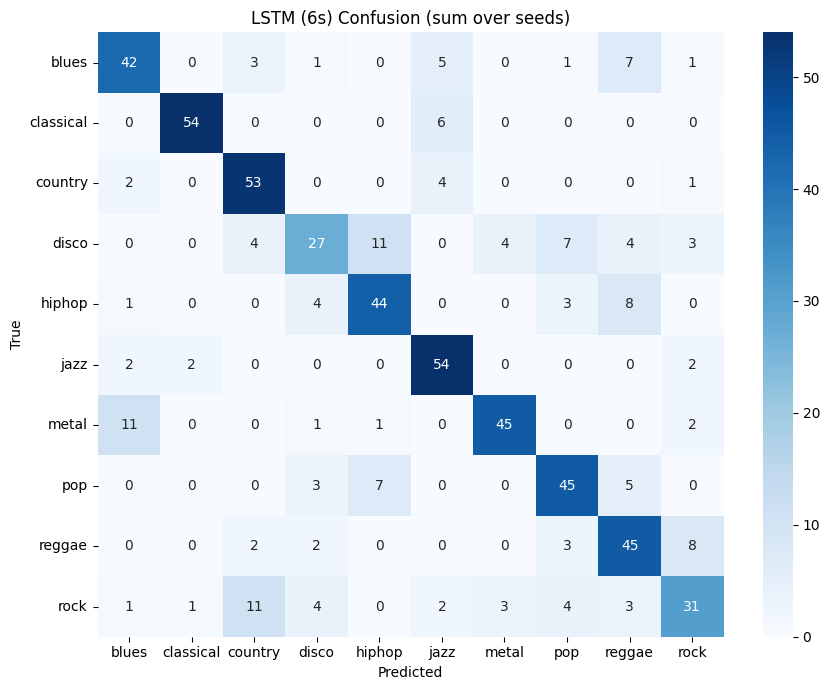


=== LSTM (9s) — Sequence-level (averaged over seeds) ===
Accuracy: 0.7317
Macro F1: 0.7292 | Weighted F1: 0.7292
blues         P=0.69  R=0.62  F1=0.65
classical     P=0.95  R=0.88  F1=0.91
country       P=0.70  R=0.83  F1=0.76
disco         P=0.64  R=0.52  F1=0.57
hiphop        P=0.63  R=0.78  F1=0.70
jazz          P=0.78  R=0.88  F1=0.83
metal         P=0.93  R=0.83  F1=0.88
pop           P=0.72  R=0.73  F1=0.72
reggae        P=0.61  R=0.72  F1=0.66
rock          P=0.79  R=0.52  F1=0.62


,Genre,Confidence,Recall
0,blues,2.68,62%
1,classical,3.64,88%
2,country,3.54,83%
3,disco,2.71,52%
4,hiphop,3.51,78%
5,jazz,4.11,88%
6,metal,2.59,83%
7,pop,3.10,73%
8,reggae,3.48,72%
9,rock,2.20,52%


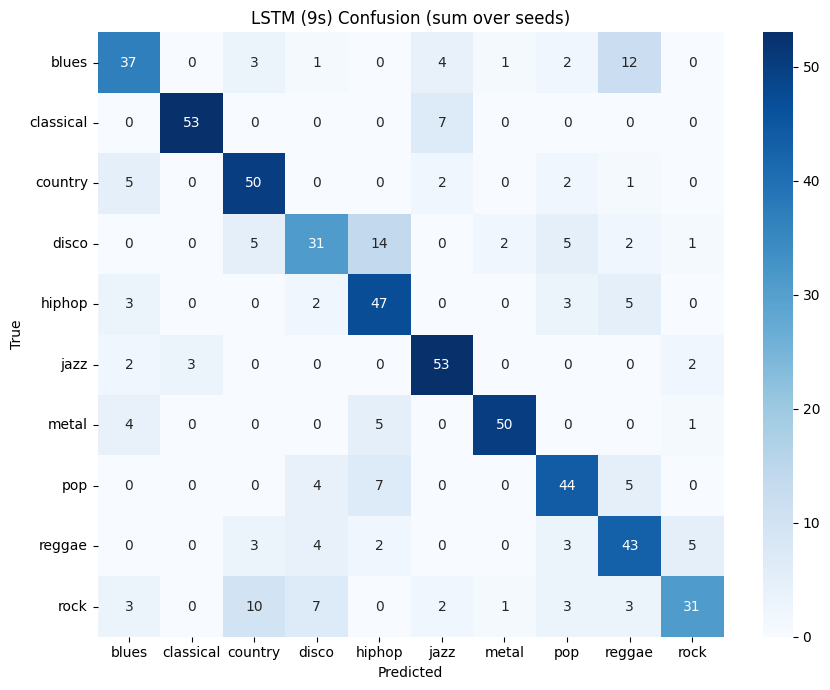

In [33]:
# ===========================
# LSTM: seed-averaged metrics
# for 3s / 6s / 9s sequences
# ===========================
import math, numpy as np, pandas as pd, torch
from sklearn.metrics import classification_report, confusion_matrix

def set_all_seeds(sd: int):
    import random
    random.seed(sd); np.random.seed(sd); torch.manual_seed(sd)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(sd)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# --- Pretty report and averaging helpers ---
def avg_report_dicts(report_list, label_names):
    keys = ['precision','recall','f1-score']
    out = {}
    out['accuracy'] = float(np.mean([r['accuracy'] for r in report_list]))
    for k in ['macro avg','weighted avg']:
        out[k] = {m: float(np.mean([r[k][m] for r in report_list])) for m in keys}
        out[k]['support'] = float(np.mean([r[k]['support'] for r in report_list]))
    for cls in label_names:
        out[cls] = {m: float(np.mean([r[cls][m] for r in report_list])) for m in keys}
        out[cls]['support'] = float(np.mean([r[cls]['support'] for r in report_list]))
    return out

def print_report_nice(title, rep, label_names):
    print(title)
    print(f"Accuracy: {rep['accuracy']:.4f}")
    print(f"Macro F1: {rep['macro avg']['f1-score']:.4f} | "
          f"Weighted F1: {rep['weighted avg']['f1-score']:.4f}")
    for cls in label_names:
        p = rep[cls]['precision']; r = rep[cls]['recall']; f = rep[cls]['f1-score']
        print(f"{cls:12s}  P={p:.2f}  R={r:.2f}  F1={f:.2f}")

def format_certainty_table(df):
    out = df.copy()
    out["Confidence"] = out["Confidence"].astype(float).round(2)
    out["Recall"] = (out["Recall"] * 100.0).round(0).astype(int).astype(str) + "%"
    return out[["Genre","Confidence","Recall"]]

# --- Certainty from sequence logits (handles optional 'lengths') ---
@torch.no_grad()
def certainty_table_for_seq_model(model, loader, label_names, device, mode="all"):
    """
    mode: "all" or "correct_only"
    Assumes model returns logits per SEQUENCE (B, C).
    Loader batch can be (X, y) or (X, lengths, y). X shape: (B, T, F) or (B, F).
    """
    model.eval()
    y_true, y_pred = [], []
    margins = []  # log10(p_top/p_second) from logits

    for batch in loader:
        # Unpack batch
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
            X, lengths, y = batch
        else:
            X, y = batch
            lengths = None

        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        # Forward
        try:
            logits = model(X, lengths) if lengths is not None else model(X)  # (B, C)
        except TypeError:
            logits = model(X)  # in case model ignores lengths

        vals, idxs = torch.topk(logits, k=2, dim=1)
        pred = idxs[:, 0]
        margin = (vals[:, 0] - vals[:, 1]) / math.log(10)  # log10 ratio

        y_true.extend(y.tolist()); y_pred.extend(pred.tolist()); margins.extend(margin.tolist())

    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    margins = np.asarray(margins, dtype=float)

    rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))

    # Build per-genre rows
    rows = []
    for c_idx, name in enumerate(label_names):
        mask_true = (y_true == c_idx)
        mask = mask_true & (y_pred == c_idx) if mode == "correct_only" else mask_true
        conf = float(np.mean(margins[mask])) if np.any(mask) else float("nan")
        recall = rep[name]["recall"]
        support = int(rep[name]["support"])
        rows.append({"Genre": name, "Confidence": conf, "Recall": recall, "Support": support})

    df = pd.DataFrame(rows, columns=["Genre","Confidence","Recall","Support"])
    return rep, cm, df

# --- Infer feature dim from a SEQUENCE loader (works for (B,T,F) or (B,F)) ---
def infer_in_dim_from_seq_loader(loader):
    batch = next(iter(loader))
    X = batch[0] if isinstance(batch, (list, tuple)) else batch
    if isinstance(X, (list, tuple)):
        X = X[0]
    if X.dim() == 3:    # (B, T, F)
        return int(X.shape[-1])
    elif X.dim() == 2:  # (B, F)
        return int(X.shape[-1])
    else:               # fallback
        return int(X.reshape(X.shape[0], -1).shape[-1])

# --- One run for LSTM on sequences with seed control ---
def run_lstm_and_report(model_fn, optimizer_fn, loss_fn,
                        train_loader, test_loader,
                        label_names, device, epochs=50, seed=42,
                        run_name="LSTM", train_fn=None, eval_mode="all"):
    set_all_seeds(seed)
    model = model_fn().to(device)
    opt   = optimizer_fn(model)

    if train_fn is None:
        train_fn = globals().get("train_lstm", globals()["train"])

    _ = train_fn(
        model=model,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        loss_fn=loss_fn,
        optimizer=opt,
        epochs=epochs,
        device=device,
        eval_every=10,
        run_name=run_name,
        seed=seed
    )

    rep_seq, cm_seq, cert_df = certainty_table_for_seq_model(model, test_loader, label_names, device, mode=eval_mode)
    return {"seed": seed, "model": model, "seq_report": rep_seq, "seq_cm": cm_seq, "certainty_df": cert_df}


hidden_dim = 128
dropout = 0.3
num_classes = len(LABELS)
seeds = (42, 123, 999)

seq_loaders = {
    "3s": (dl_tr_3s, dl_te_3s),
    "6s": (dl_tr_6s, dl_te_6s),
    "9s": (dl_tr_9s, dl_te_9s),
}

all_results, avg_reports, tables, cms = {}, {}, {}, {}

for dur, (tr_loader, te_loader) in seq_loaders.items():
    runs = []
    for sd in seeds:
        out = run_lstm_and_report(
            model_fn=lambda: LSTMModel(
                input_size=58,
                hidden_size=hidden_dim,
                num_layers=2,
                num_classes=num_classes,
                dropout=dropout
            ),
            optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3),
            loss_fn=loss_fn,
            train_loader=tr_loader,
            test_loader=te_loader,
            label_names=LABELS,
            device=device,
            epochs=50,
            seed=sd,
            run_name=f"LSTM-{dur}",
            eval_mode="all",
        )
        runs.append(out)

    all_results[dur] = runs

    # average sklearn report
    rep_list = [r["seq_report"] for r in runs]
    avg_reports[dur] = avg_report_dicts(rep_list, LABELS)

    # average certainty table
    stack = [r["certainty_df"][["Genre","Confidence","Recall"]].set_index("Genre") for r in runs]
    avg_df = pd.concat(stack, axis=1).groupby(level=0, axis=1).mean()
    final_df = avg_df.reset_index().set_index("Genre").loc[LABELS].reset_index()
    tables[dur] = format_certainty_table(final_df)

    # sum confusion matrices
    cm_sum = None
    for r in runs:
        cm = r["seq_cm"]
        cm_sum = cm if cm_sum is None else (cm_sum + cm)
    cms[dur] = cm_sum

# display
for dur in ("3s","6s","9s"):
    print_report_nice(f"\n=== LSTM ({dur}) — Sequence-level (averaged over seeds) ===", avg_reports[dur], LABELS)
    display(tables[dur])
    try:
        plot_confusion(cms[dur], LABELS, title=f"LSTM ({dur}) Confusion (sum over seeds)")
    except NameError:
        pass



In [34]:
import numpy as np
import matplotlib.pyplot as plt


def aggregate_histories_safe(histories, keys=("train_loss","test_loss","train_acc","test_acc")):
    """
    Aggregate lists of metric sequences across runs; skip runs missing a metric.
    Returns: agg (dict: key -> (mu, sd) or (None, None)), L (common length used).
    """
    # find the shortest available length among present keys
    lengths = []
    for h in histories:
        for k in keys:
            if k in h and isinstance(h[k], (list, tuple)) and len(h[k]) > 0:
                lengths.append(len(h[k]))
    if not lengths:
        raise ValueError("No plottable metric sequences found in histories.")
    L = min(lengths)

    agg = {}
    for k in keys:
        series = []
        for h in histories:
            if k in h and isinstance(h[k], (list, tuple)) and len(h[k]) >= L:
                series.append(np.asarray(h[k][:L], dtype=float))
        if series:
            arr = np.stack(series, axis=0)  # [num_runs, L]
            agg[k] = (arr.mean(axis=0), arr.std(axis=0))
        else:
            agg[k] = (None, None)
    return agg, L

def plot_lstm_curves(histories, run_name="LSTM", step=5):

    agg, L = aggregate_histories_safe(histories)
    epochs = np.arange(L)

    plt.figure(figsize=(13,5))

    # ---- Loss ----
    plt.subplot(1,2,1)
    for k, lbl in (("train_loss","Train"), ("test_loss","Test")):
        mu, sd = agg[k]
        if mu is None:  # skip if missing
            continue
        plt.plot(epochs, mu, label=f"{lbl} loss")
        plt.fill_between(epochs, mu - sd, mu + sd, alpha=0.2)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{run_name} Loss"); plt.legend()

    # ---- Accuracy ----
    plt.subplot(1,2,2)
    for k, lbl in (("train_acc","Train"), ("test_acc","Test")):
        mu, sd = agg[k]
        if mu is None:
            continue
        plt.plot(epochs, mu, label=f"{lbl} acc")
        plt.fill_between(epochs, mu - sd, mu + sd, alpha=0.2)
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title(f"{run_name} Accuracy"); plt.legend()

    plt.tight_layout()
    plt.show()


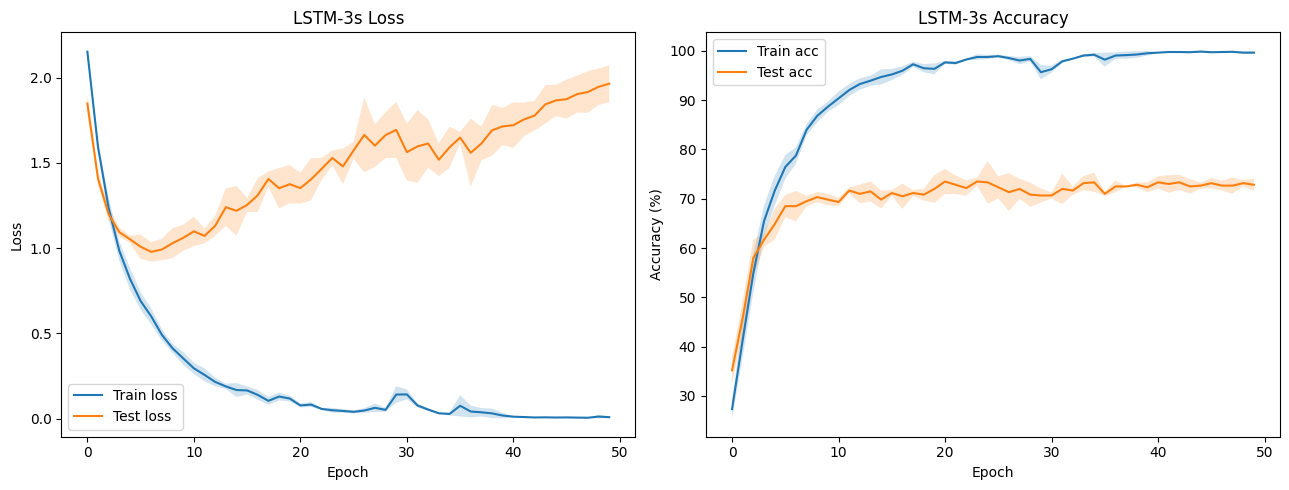

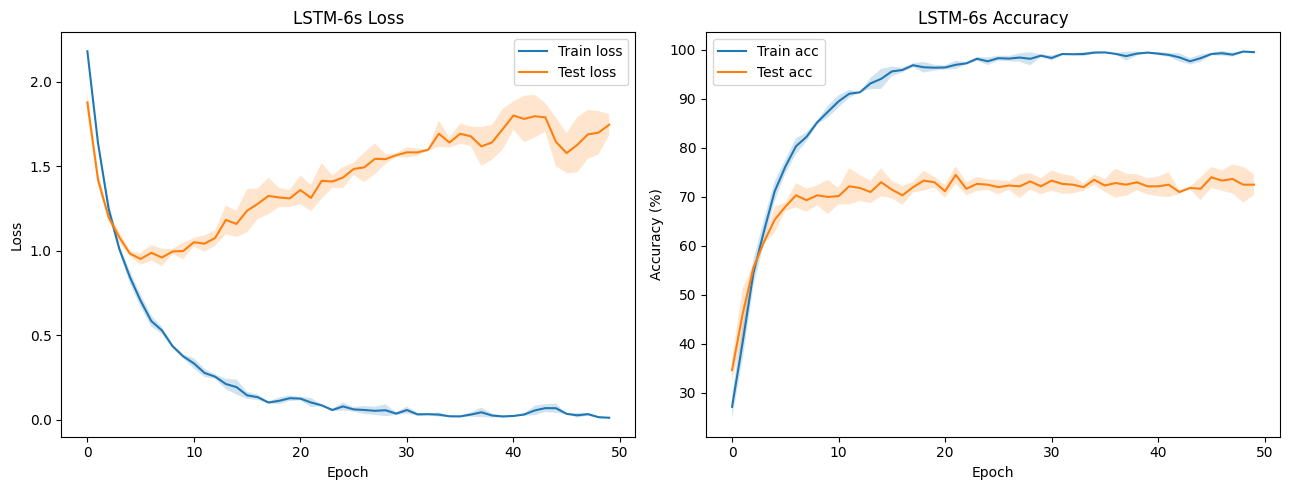

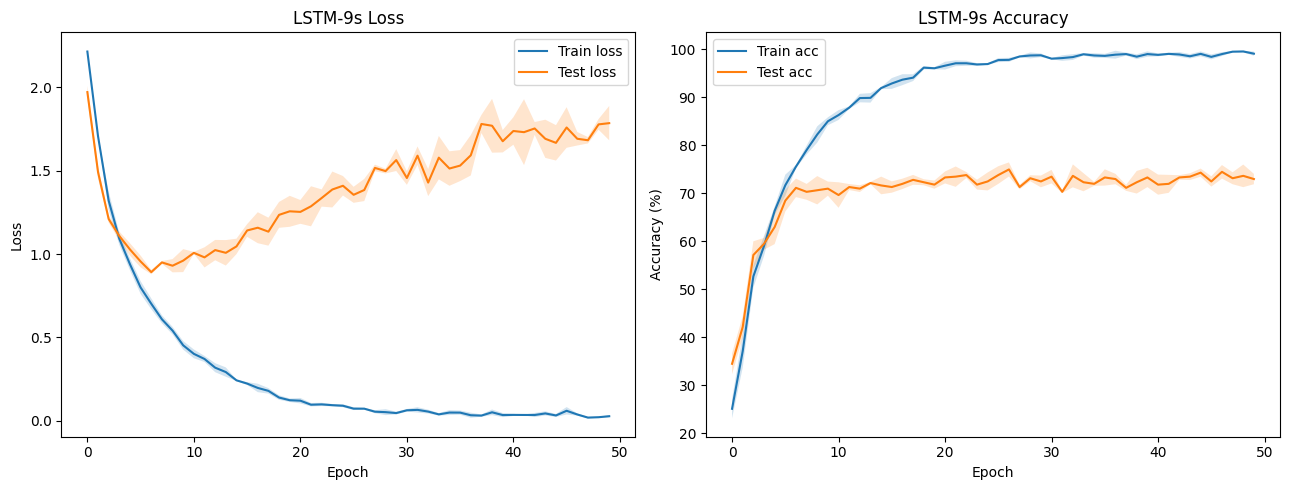

In [35]:
plot_lstm_curves(exp_3_lstm, run_name="LSTM-3s")
plot_lstm_curves(exp_6_lstm, run_name="LSTM-6s")
plot_lstm_curves(exp_9_lstm, run_name="LSTM-9s")


In [36]:
def probe_loader(name, loader, expect_seq=True):
    print(f"\n[{name}]")
    n_items = len(loader.dataset)
    n_batches = len(loader)
    print(f"  dataset size: {n_items}")
    print(f"  num batches : {n_batches}")
    try:
        batch = next(iter(loader))
    except StopIteration:
        print("  FIRST BATCH: (empty)")
        return
    if isinstance(batch, (list, tuple)):
        X = batch[0]
        y = batch[1]
    else:
        X, y = batch

    print(f"  X dtype/shape: {X.dtype}, {tuple(X.shape)}")
    print(f"  y dtype/shape: {y.dtype}, {tuple(y.shape)}")
    if expect_seq:
        assert X.ndim == 3, f"Expected [B, T, F] but got {tuple(X.shape)}"
        print(f"  seq lens T in this batch: {X.shape[1]}")
    print(f"  y.min..max: {int(y.min()) if y.numel() else 'NA'} .. {int(y.max()) if y.numel() else 'NA'}")


In [37]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds_seq(model, loader, device):
    """Collect y_true, y_pred, y_prob from a sequence (clip-level) loader."""
    model.eval()
    ys, yhats, yprobs = [], [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        prob = torch.softmax(logits, dim=1)
        yhat = prob.argmax(1).cpu().numpy()
        ys.append(y.cpu().numpy())
        yhats.append(yhat)
        yprobs.append(prob.cpu().numpy())
    if len(ys) == 0:
        return np.array([]), np.array([]), np.array([])
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(yhats)
    y_prob = np.concatenate(yprobs)
    return y_true, y_pred, y_prob

def plot_confmat(cm, labels, normalize=True, title="Confusion matrix"):
    """Pretty confusion matrix plot."""
    if normalize:
        with np.errstate(invalid="ignore"):
            cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
            cmn = np.nan_to_num(cmn)
        M = cmn
        fmt = ".2f"
    else:
        M = cm
        fmt = "d"

    fig, ax = plt.subplots(figsize=(7.5, 6.5))
    im = ax.imshow(M, interpolation='nearest', cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           ylabel='True label', xlabel='Predicted label', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = M.max() * 0.6
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, format(M[i, j], fmt),
                    ha="center", va="center",
                    color="white" if M[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()



[LSTM-3s | seed=42] Epoch 000 | Train 2.1448 Acc 25.19% | Test 1.7983 Acc 37.00%
[LSTM-3s | seed=42] Epoch 010 | Train 0.3015 Acc 90.89% | Test 1.0237 Acc 68.50%
[LSTM-3s | seed=42] Epoch 020 | Train 0.0796 Acc 97.59% | Test 1.3943 Acc 71.00%
[LSTM-3s | seed=42] Epoch 030 | Train 0.1056 Acc 97.22% | Test 1.5054 Acc 70.50%
[LSTM-3s | seed=42] Epoch 040 | Train 0.0119 Acc 99.62% | Test 1.7535 Acc 73.00%
[LSTM-3s | seed=42] Epoch 049 | Train 0.0066 Acc 99.75% | Test 2.0024 Acc 72.50%
[LSTM-3s | seed=123] Epoch 000 | Train 2.1556 Acc 26.96% | Test 1.8199 Acc 31.50%
[LSTM-3s | seed=123] Epoch 010 | Train 0.3320 Acc 88.48% | Test 1.0524 Acc 69.00%
[LSTM-3s | seed=123] Epoch 020 | Train 0.0908 Acc 97.34% | Test 1.2269 Acc 77.00%
[LSTM-3s | seed=123] Epoch 030 | Train 0.1771 Acc 96.08% | Test 1.3948 Acc 71.50%
[LSTM-3s | seed=123] Epoch 040 | Train 0.0162 Acc 99.62% | Test 1.5444 Acc 75.00%
[LSTM-3s | seed=123] Epoch 049 | Train 0.0158 Acc 99.37% | Test 1.8182 Acc 74.50%
[LSTM-3s | seed=999] E

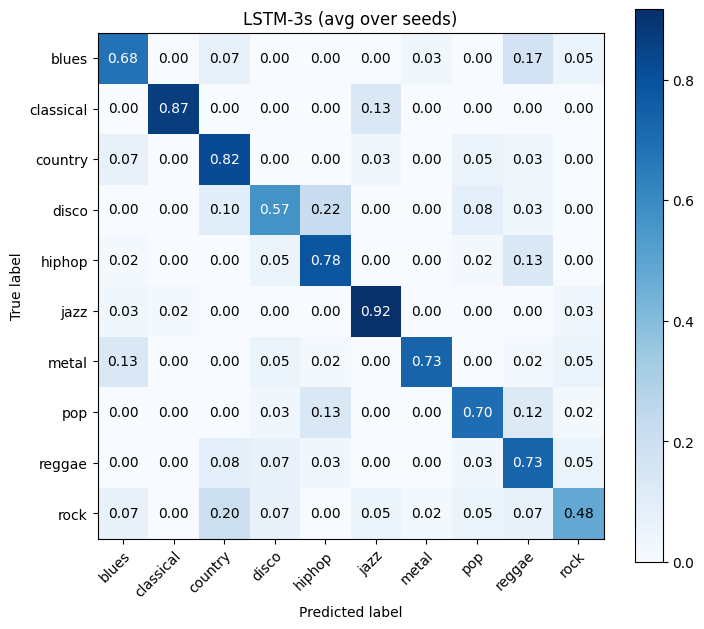

[LSTM-6s | seed=42] Epoch 000 | Train 2.1768 Acc 24.56% | Test 1.8287 Acc 36.50%
[LSTM-6s | seed=42] Epoch 010 | Train 0.3418 Acc 89.49% | Test 1.0806 Acc 68.00%
[LSTM-6s | seed=42] Epoch 020 | Train 0.1178 Acc 95.95% | Test 1.3101 Acc 70.00%
[LSTM-6s | seed=42] Epoch 030 | Train 0.0344 Acc 98.99% | Test 1.5739 Acc 73.00%
[LSTM-6s | seed=42] Epoch 040 | Train 0.0178 Acc 99.62% | Test 1.7595 Acc 71.00%
[LSTM-6s | seed=42] Epoch 049 | Train 0.0106 Acc 99.49% | Test 1.8335 Acc 70.50%
[LSTM-6s | seed=123] Epoch 000 | Train 2.1818 Acc 26.71% | Test 1.8433 Acc 31.50%
[LSTM-6s | seed=123] Epoch 010 | Train 0.3671 Acc 87.97% | Test 1.0194 Acc 70.50%
[LSTM-6s | seed=123] Epoch 020 | Train 0.1188 Acc 96.96% | Test 1.2904 Acc 73.00%
[LSTM-6s | seed=123] Epoch 030 | Train 0.0545 Acc 98.35% | Test 1.5518 Acc 76.00%
[LSTM-6s | seed=123] Epoch 040 | Train 0.0271 Acc 98.86% | Test 1.9164 Acc 75.00%
[LSTM-6s | seed=123] Epoch 049 | Train 0.0175 Acc 99.49% | Test 1.7193 Acc 71.50%
[LSTM-6s | seed=999] E

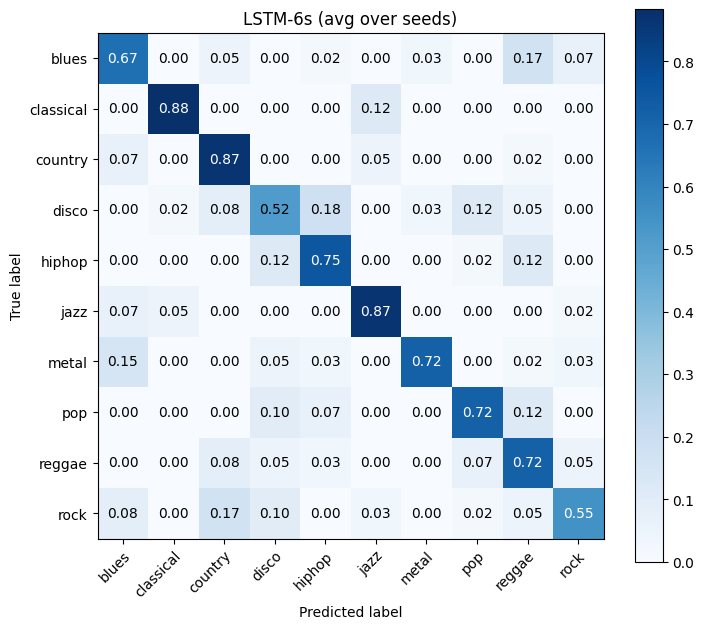

[LSTM-9s | seed=42] Epoch 000 | Train 2.2105 Acc 22.75% | Test 1.9552 Acc 36.50%
[LSTM-9s | seed=42] Epoch 010 | Train 0.4191 Acc 86.50% | Test 1.0036 Acc 69.50%
[LSTM-9s | seed=42] Epoch 020 | Train 0.1416 Acc 95.50% | Test 1.2057 Acc 73.00%
[LSTM-9s | seed=42] Epoch 030 | Train 0.0580 Acc 98.00% | Test 1.5082 Acc 72.50%
[LSTM-9s | seed=42] Epoch 040 | Train 0.0435 Acc 98.50% | Test 1.6237 Acc 74.00%
[LSTM-9s | seed=42] Epoch 049 | Train 0.0332 Acc 98.50% | Test 1.8708 Acc 71.50%
[LSTM-9s | seed=123] Epoch 000 | Train 2.2130 Acc 25.00% | Test 1.9355 Acc 31.50%
[LSTM-9s | seed=123] Epoch 010 | Train 0.4209 Acc 85.00% | Test 1.0155 Acc 66.50%
[LSTM-9s | seed=123] Epoch 020 | Train 0.1186 Acc 97.38% | Test 1.1995 Acc 75.00%
[LSTM-9s | seed=123] Epoch 030 | Train 0.0737 Acc 98.00% | Test 1.4526 Acc 72.50%
[LSTM-9s | seed=123] Epoch 040 | Train 0.0337 Acc 98.88% | Test 1.7781 Acc 72.50%
[LSTM-9s | seed=123] Epoch 049 | Train 0.0294 Acc 99.38% | Test 1.8449 Acc 74.00%
[LSTM-9s | seed=999] E

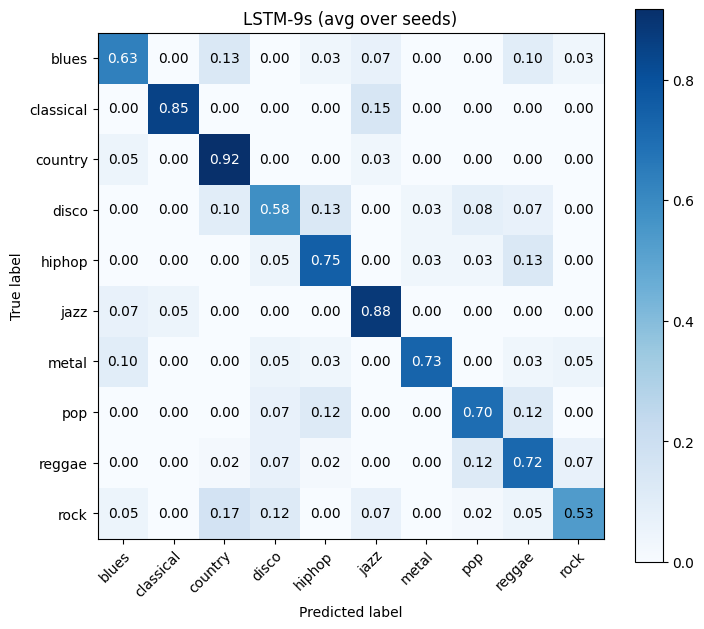

In [38]:
from collections import defaultdict

def average_seed_report(model_ctor, train_loader, test_loader, seeds, labels, device, epochs=50, title=""):
    all_true, all_pred = [], []
    for sd in seeds:
        set_all_seeds(sd)
        model = model_ctor().to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        _ = train_lstm(model, train_loader, test_loader, loss_fn, opt,
                       epochs=epochs, device=device, run_name=title, seed=sd, eval_every=10)
        y_true, y_pred, _ = get_preds_seq(model, test_loader, device)
        all_true.append(y_true); all_pred.append(y_pred)

    y_true_cat = np.concatenate(all_true)
    y_pred_cat = np.concatenate(all_pred)
    print(f"{title} (seeds={list(seeds)}) | Accuracy: {(y_true_cat==y_pred_cat).mean()*100:.2f}%\n")
    print(classification_report(y_true_cat, y_pred_cat, target_names=labels, digits=3))
    cm = confusion_matrix(y_true_cat, y_pred_cat, labels=np.arange(len(labels)))
    plot_confmat(cm, labels, normalize=True, title=f"{title} (avg over seeds)")
    return y_true_cat, y_pred_cat, cm

# Example: average across three seeds for 3s
_ = average_seed_report(
        model_ctor=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=len(LABELS), dropout=0.2),
        train_loader=dl_tr_3s,
        test_loader=dl_te_3s,
        seeds=(42,123,999),
        labels=LABELS,
        device=device,
        epochs=50,
        title="LSTM-3s"
)

# Example: average across three seeds for 6s
_ = average_seed_report(
        model_ctor=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=len(LABELS), dropout=0.2),
        train_loader=dl_tr_6s,
        test_loader=dl_te_6s,
        seeds=(42,123,999),
        labels=LABELS,
        device=device,
        epochs=50,
        title="LSTM-6s"
)

# Example: average across three seeds for 9s
_ = average_seed_report(
        model_ctor=lambda: LSTMModel(input_size=58, hidden_size=64, num_layers=2, num_classes=len(LABELS), dropout=0.2),
        train_loader=dl_tr_9s,
        test_loader=dl_te_9s,
        seeds=(42,123,999),
        labels=LABELS,
        device=device,
        epochs=50,
        title="LSTM-9s"
        )


### Summary and Reflections

- The **MLP model** achieved competitive performance on 30-second and 3-second windows, demonstrating that static feature representations alone can capture much of the genre structure in GTZAN.
- The **LSTM model** improved stability across temporal sequences but did not fully reproduce the extremely high accuracies reported in the paper.
- Our experiments suggest that preprocessing, normalization choices, and data leakage handling have a **larger impact** on final results than model complexity alone.

Future work could explore:
- Data augmentation and overlapping windows to increase training diversity.
- Hybrid CNN-LSTM architectures for richer temporal feature extraction.
- Evaluating on leakage-controlled splits to better measure generalization.
